<a href="https://colab.research.google.com/github/Alejandro405/tfg/blob/main/ML_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Clásico para AIDS

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

def plot_and_save_hyperparameter_impacts(search, output_dir='plots'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    results_df = search.cv_results_

    # Identify all the hyperparameters used in the search
    hyperparameters = [key for key in results_df.keys() if key.startswith('param_')]

    for param in hyperparameters:
        param_values = np.array(results_df[param].tolist()).flatten()
        unique_param_values = np.unique(param_values)
        plot_data = []

        for value in param_values:
            scores = results_df[results_df[param] == value]['mean_test_score']
            for score in scores:
                plot_data.append({'Hyperparameter Value': value, 'Score': score})

        plot_df = pd.DataFrame(plot_data)

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Hyperparameter Value', y='Score', data=plot_df)
        plt.title(f'Impact of {param.replace("param_", "")} on Score')
        plt.xlabel(param.replace('param_', ''))
        plt.ylabel('F1 - Score')
        plt.xticks(rotation=45)

        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{param.replace("param_", "")}_impact.png')
        plt.savefig(file_path)
        plt.close()



# plot_hyperparameter_impacts(random_search)

## K Nearest Neightbours - KNN


Descartado por los problemas de sesgo en datos de clases desbalanceados, y el mal rendimiento tanto en eficiencia y predicciones (sesgo en el entrenamiento)

## Support Vector Machine - SVM

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import classification_report, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import uniform

def target_encode(df, cat_columns, target_column, alpha=1):
    # Verificar si las columnas categóricas están presentes en el DataFrame
    missing_columns = [col for col in cat_columns if col not in df.columns]
    if missing_columns:
        print(f"Advertencia: Las siguientes columnas categóricas están ausentes en el DataFrame: {', '.join(missing_columns)}")
        cat_columns = [col for col in cat_columns if col not in missing_columns]

    # Realizar codificación manual en la columna objetivo si no es numérica
    if not np.issubdtype(df[target_column].dtype, np.number):
        target_encoded = df[target_column].map({'anomaly': 1, 'normal': 0})
    else:
        target_encoded = df[target_column]

    for col in cat_columns:
        freq = df[col].value_counts(normalize=True)
        try:
            mean_target = df.groupby(col).apply(lambda group: target_encoded[group.index].mean())
            sample_size = df.shape[0]

            encoded_values = (freq * mean_target + alpha) / (freq + alpha * sample_size)
            encoding_map = dict(zip(encoded_values.index, encoded_values.values))

            df[col] = df[col].map(encoding_map)
        except Exception as e:
            print(f"Advertencia: No se pudo codificar la columna '{col}' debido al error: {str(e)}")

    return df

dataset_name = 'nsl-kdd'

raw_df = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/{dataset_name}.csv')
#raw_df = pd.read_csv(f'./drive/MyDrive/{dataset_name}/{dataset_name}.csv')

#raw_df.rename(columns={'Class':'Label'}, inplace=True)

cat_cols = raw_df.drop('Label', axis=1).select_dtypes(include=['object'])
#cat_cols = raw_df.drop('Class', axis=1).select_dtypes(include=['object'])

df = raw_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=.32))
#df = raw_df.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=.75))
#df.drop(columns=['Class_encoded'], inplace=True)
#df.rename(columns={'Class':'Label'}, inplace=True)

In [ ]:
!du -ha ./drive/MyDrive/nsl-kdd/results/*.csv

2.7M	./drive/MyDrive/nsl-kdd/results/a_KDDTrain+.csv_test.csv
8.1M	./drive/MyDrive/nsl-kdd/results/a_KDDTrain+.csv_train.csv
9.5K	./drive/MyDrive/nsl-kdd/results/corr_matrix.csv
12M	./drive/MyDrive/nsl-kdd/results/escalado_ecodeado_nsl_kdd.csv
4.5K	./drive/MyDrive/nsl-kdd/results/hyperparameter_tunning_trials.csv
9.7M	./drive/MyDrive/nsl-kdd/results/nsl-kdd.csv
1.9M	./drive/MyDrive/nsl-kdd/results/nsl-kdd_test.csv
11M	./drive/MyDrive/nsl-kdd/results/nsl-kdd_train.csv
1.4M	./drive/MyDrive/nsl-kdd/results/X_test.csv
3.2M	./drive/MyDrive/nsl-kdd/results/X_train.csv
109K	./drive/MyDrive/nsl-kdd/results/y_test.csv
326K	./drive/MyDrive/nsl-kdd/results/y_train.csv


In [ ]:
columns = ['same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate',
       'dst_host_same_srv_rate', 'dst_host_srv_count',
       'dst_host_srv_serror_rate', 'srv_serror_rate', 'dst_host_diff_srv_rate',
       'serror_rate', 'count', 'rerror_rate', 'wrong_fragment',
       'dst_host_rerror_rate', 'dst_host_count', 'service',
       'dst_host_srv_rerror_rate', 'logged_in', 'diff_srv_rate',
       'srv_diff_host_rate', 'srv_rerror_rate']

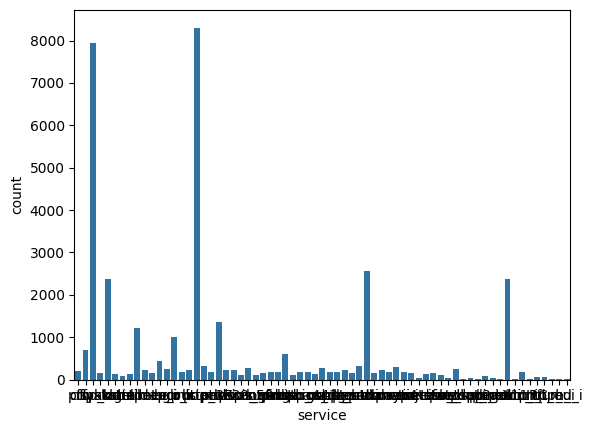

In [ ]:
for col in cat_cols:
    sns.countplot(x=col, data=df)
    plt.show()

El dataset cse-cic, despues de la depuracion no presenta variables categóricas

In [ ]:
one_hot_encoded = pd.get_dummies(df['srcip'], drop_first=True)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(['srcip'], axis=1, inplace=True)

KeyError: 'srcip'

In [ ]:
# df = target_encode(df, ['proto', 'state'], 'Label') # unsw nb15
df = target_encode(df, ['service'], 'Label')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler = StandardScaler()
scaler = MinMaxScaler() # para NSL KDD

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df_scaled_features = scaler.fit_transform(df.drop('Label', axis=1))
df[df.drop('Label', axis=1).columns] = df_scaled_features

In [ ]:
df.info()

In [ ]:
X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.33,
    stratify=y,
)

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Para cse-cic
#X_train_resampled, y_train_resampled = X_train, y_train

El escalado de datos no resulta apropiado, ya que arroja demasiados valores NaN, que al ser ignoorados en el entrenamiento pueden dar lugar a cierto sesgo, ya que no se tiene control del número de observaciones de cada clase que se tiene encuenta

Determinar el tipo de kernel óptimo

**UNSW-NB15**

In [ ]:
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [ ]:
poly_grid_search = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['poly'],
    'degree': [2, 3, 4, 5, 6],  # Grados del polinomio
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 1.0]  # Término independiente en la función del kernel polinomial
}

n_combinations = np.prod([len(param_distributions[param]) for param in param_distributions])

In [ ]:
{
    'C': [0.1, 1, 10, 100],
    'kernel': ['poly', 'linear', 'rbf'],
    'degree': [2, 3, 4, 5, 6],
    'coef0': [0.0, 1.0],
    'gamma': ['scale', 'auto']
}

**CSE-CIC**

In [ ]:
poly_grid_search = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4, 5, 6],
    'gamma': ['scale', 'auto']
}

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
    'degree': [2, 3, 4, 5]  # Este parámetro solo será relevante para el kernel 'poly'
}

In [ ]:
param_distributions = {
    # 'C': [0.01, 0.1, 1, 10],
    'C': [0.01],
    #'kernel': ['poly', 'linear', 'rbf'],
    'kernel': ['poly'],
    #'degree': [2, 3, 6],  # Grados del polinomio
    'degree': [2],
    #'gamma': ['scale', 'auto']
    'gamma':['scale'],
    'coef0': [0.0, 1.0]  # Término independiente en la función del kernel polinomial
}

n_combinations = np.prod([len(param_distributions[param]) for param in param_distributions])

**NSL-KDD**

In [ ]:
poly_grid_search = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [ ]:
param_distributions = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['poly', 'linear', 'rbf'],
    'degree': [2, 3, 4, 5, 6],  # Grados del polinomio
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.5, 1.0]  # Término independiente en la función del kernel polinomial
}

n_combinations = np.prod([len(param_distributions[param]) for param in param_distributions])

In [ ]:
from sklearn.metrics import make_scorer, f1_score


svm_classifier = SVC(
    class_weight='balanced',
    verbose=False,
    max_iter=1000,
    tol=0.005,
    cache_size=2000,
    random_state=42
)

f1_weighted = make_scorer(f1_score, average='weighted')

# Inicializar RandomizedSearchCV para búsqueda de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=svm_classifier,
    param_distributions=param_distributions,
    n_iter=100,
    #n_iter=n_combinations,  # Número de combinaciones de parámetros a probar
    cv=2,  # Reducir el número de validaciones cruzadas
    n_jobs=-1,
    scoring=f1_weighted,
    return_train_score=True,
    verbose=3
)

# Realizar la búsqueda de hiperparámetros en el conjunto de datos submuestreado
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RandomizedSearchCV(cv=2,
                   estimator=SVC(cache_size=2000, class_weight='balanced',
                                 max_iter=1000, random_state=42, tol=0.005),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'coef0': [0.0, 0.1, 0.5, 1.0],
                                        'degree': [2, 3, 4, 5, 6],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['poly', 'linear', 'rbf']},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [ ]:
svm_classifier = SVC(
    class_weight='balanced',
    verbose=True,
    max_iter=200,
    tol=0.05,
    cache_size=2000,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=svm_classifier,
    param_grid=poly_grid_search,
    cv=2,
    n_jobs=-1,
    scoring='f1',
    return_train_score=True,
    verbose=3
)
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan]
  warnings.warn(


[LibSVM]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=SVC(cache_size=2000, class_weight='balanced',
                           max_iter=200, random_state=42, tol=0.05,
                           verbose=True),
             n_jobs=-1,
             param_grid={'gamma': ['scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True, scoring='f1', verbose=3)

In [ ]:
resultados_rnd = pd.DataFrame(random_search.cv_results_)
#resultados_grid = pd.DataFrame(grid_search.cv_results_)

In [ ]:
resultados_rnd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_degree,param_coef0,param_C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,16.458615,11.688954,10.761608,9.783244,poly,scale,6,0.1,0.1,"{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.334056,0.333468,0.333762,0.000294,81,0.334134,0.333457,0.333795,0.000338
1,30.471741,1.088593,48.904439,0.768435,rbf,auto,4,0.5,0.01,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 4...",0.941347,0.851321,0.896334,0.045013,25,0.940660,0.852622,0.896641,0.044019
2,21.301301,3.123334,17.960243,2.522169,poly,auto,5,0.1,0.1,"{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.333434,0.333497,0.333466,0.000032,89,0.333440,0.333471,0.333456,0.000016
3,25.263862,1.783284,19.217102,0.340934,linear,scale,6,0.0,0.1,"{'kernel': 'linear', 'gamma': 'scale', 'degree...",0.736067,0.421856,0.578962,0.157106,55,0.736560,0.420367,0.578464,0.158097
4,26.669259,0.778673,20.521741,0.263329,poly,scale,4,0.0,0.01,"{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.333342,0.333451,0.333397,0.000055,96,0.333328,0.333474,0.333401,0.000073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,23.502792,0.598169,16.795127,0.488214,linear,scale,4,0.1,1,"{'kernel': 'linear', 'gamma': 'scale', 'degree...",0.346712,0.988004,0.667358,0.320646,45,0.346933,0.988425,0.667679,0.320746
96,20.745394,0.509329,16.980399,0.035158,linear,scale,2,0.1,1,"{'kernel': 'linear', 'gamma': 'scale', 'degree...",0.346712,0.988004,0.667358,0.320646,45,0.346933,0.988425,0.667679,0.320746
97,31.468725,0.095051,48.983629,0.152037,rbf,auto,2,0.0,10,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 2...",0.927200,0.975002,0.951101,0.023901,4,0.926759,0.975910,0.951334,0.024576
98,19.861705,4.788133,15.914273,3.355608,poly,scale,4,0.5,1,"{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.334603,0.333457,0.334030,0.000573,79,0.334718,0.333500,0.334109,0.000609


In [ ]:
results_df = resultados_rnd
results_df.to_csv(f'/content/drive/MyDrive/unsw-nb15/results/svm/hyperparameters_results.csv', header=True, index=False)

In [ ]:
scores = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/svm/hyperparameters_results.csv')

FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/nsl-kdd/results/svm/hyperparameters_results.csv'

<ipython-input-41-55755b97abb1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='param_kernel', y='mean_test_score', palette='viridis')


<Axes: xlabel='param_kernel', ylabel='mean_test_score'>

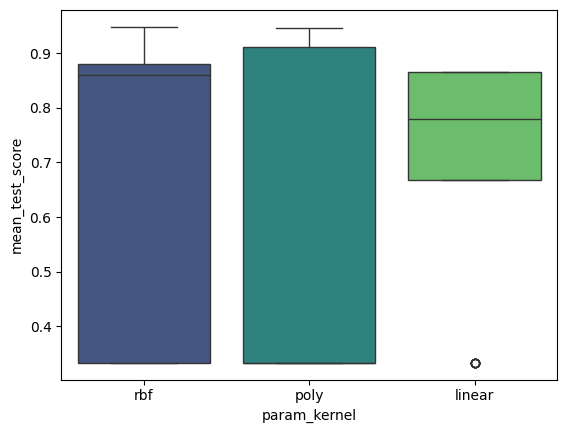

In [ ]:
params = results_df['param_kernel']
scores = results_df['mean_test_score']

plot_df = pd.concat([params, scores], axis=1)

sns.boxplot(data=results_df, x='param_kernel', y='mean_test_score', palette='viridis')

In [ ]:
resultados = resultados_grid
param_dist = param_distributions

train_scores = {}
test_scores = {}

# Iterar sobre los hiperparámetros y sus valores
for param, param_values in param_dist.items():
    train_scores[param] = []
    test_scores[param] = []
    for value in param_values:
        # Filtrar los resultados para el valor actual del hiperparámetro
        mask = resultados['param_' + param] == value

        # Calcular la media de los puntajes de entrenamiento y prueba para el valor actual del hiperparámetro
        train_score_mean = resultados[mask]['mean_train_score'].mean()
        test_score_mean = resultados[mask]['mean_test_score'].mean()

        # Almacenar los puntajes medios en los diccionarios
        train_scores[param].append(train_score_mean)
        test_scores[param].append(test_score_mean)

In [ ]:
plot_and_save_hyperparameter_impacts(grid_search, f'./drive/MyDrive/{dataset_name}/results/svm/hyperparameters_results.csv')

TypeError: unhashable type: 'MaskedArray'

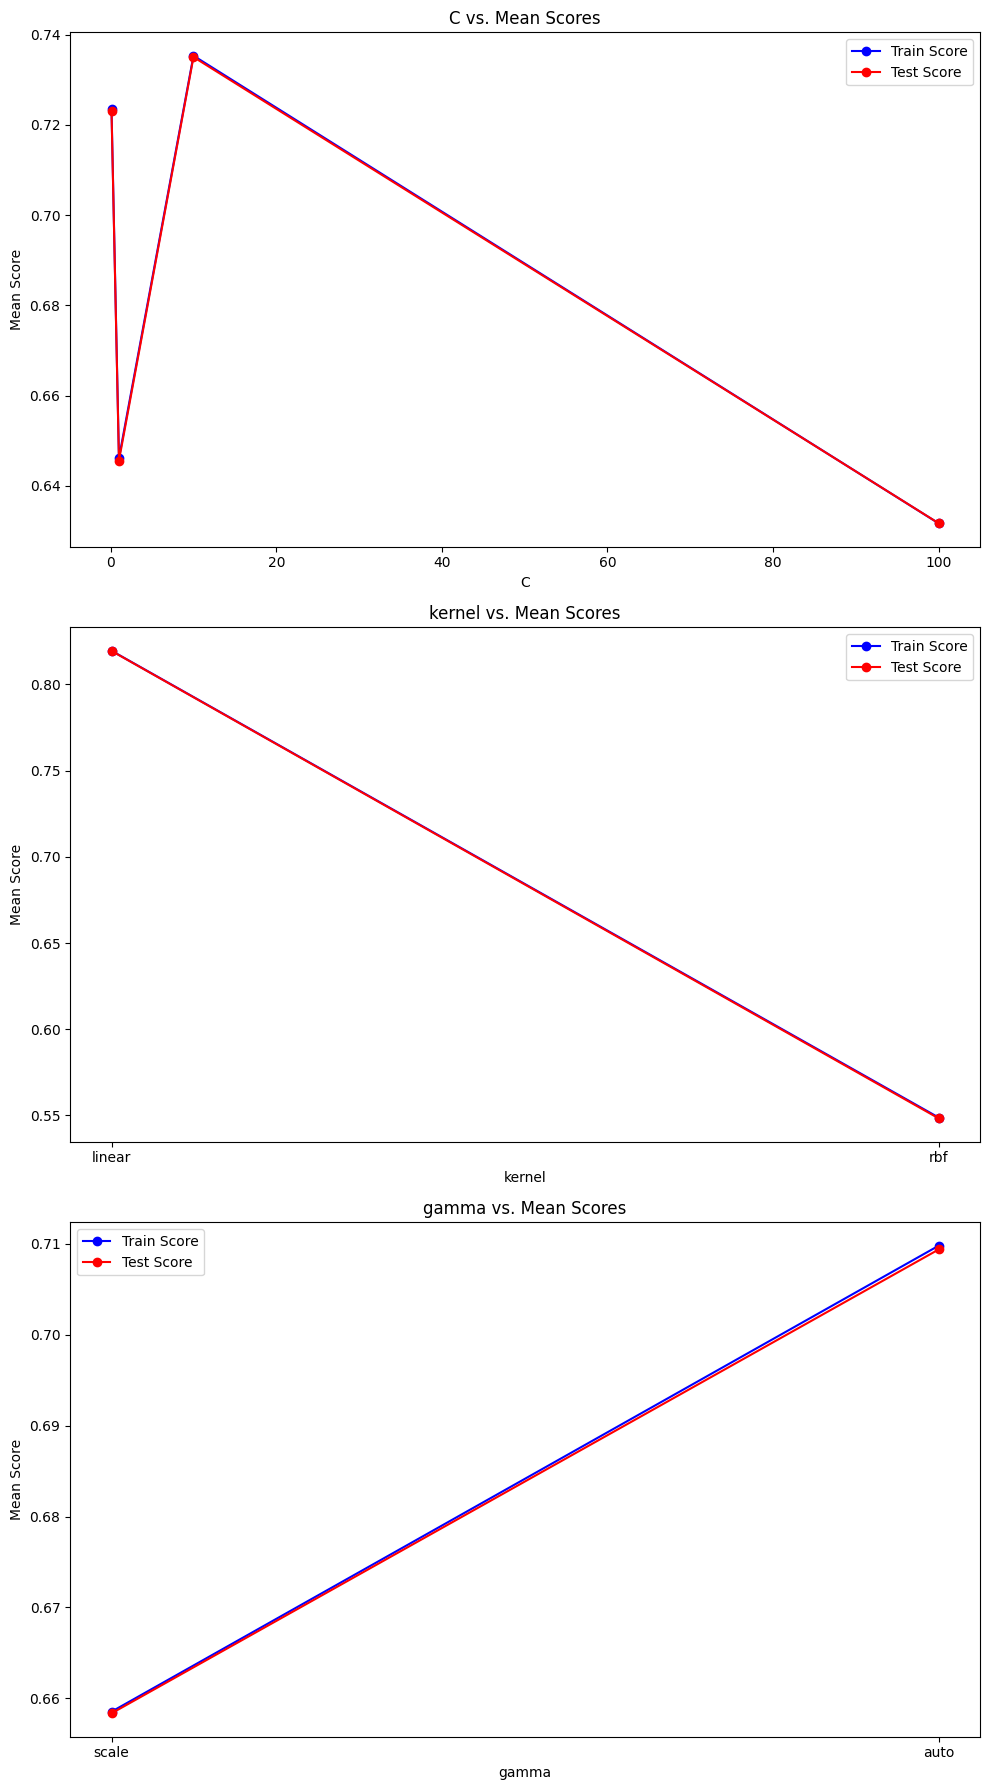

In [ ]:
import matplotlib.pyplot as plt

# Crear subgráficos para cada hiperparámetro
num_subplots = len(train_scores)

# Definir colores para los trazos
colors = ['blue', 'red', 'green', 'orange']

fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

# Iterar sobre los hiperparámetros y sus valores
for i, (param, values) in enumerate(train_scores.items()):
    ax = axes[i]
    ax.plot(param_dist[param], train_scores[param], color='blue', marker='o', label='Train Score')
    ax.plot(param_dist[param], test_scores[param], color='red', marker='o', label='Test Score')
    ax.set_title(f'{param} vs. Mean Scores')
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Score')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Mejor modelo SVM entrenado con los mejores parámetros
best_svm_classifier = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_svm_classifier.predict(X_test)

# Evaluar el rendimiento del clasificador
print(classification_report(y_test, y_pred))

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
#print(f"Accuracy: {accuracy}")
#print(f"F1 Score: {f1}")

In [ ]:
best_params = random_search.best_params_
print("Mejores parámetros encontrados:", best_params)

best_svm_classifier = random_search.best_estimator_
y_pred = best_svm_classifier.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

y_test_binary = y_test.map({'anomaly': 1, 'normal': 0})
y_pred_binary = pd.Series(y_pred).map({'anomaly': 1, 'normal': 0})

# Métricas de rendimiento
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
print("Métricas de rendimiento del modelo en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Mejores parámetros encontrados: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


ValueError: Input y_true contains NaN.

### Comparación y selección de modelos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve

from scipy.stats import levene

import time
import os
import joblib

In [ ]:
dataset_name = 'cse-cic'

In [ ]:
loaded_models = {}

model_names = ['SVM_Linear', 'SVM_Poly']
save_dir = f"./drive/MyDrive/{dataset_name}/results/svm/saved_models"
for name in model_names:
    model_filename = os.path.join(save_dir, f"{name}_model.joblib")
    loaded_models[name] = joblib.load(model_filename)

In [ ]:
svm_poly = loaded_models['SVM_Poly']

In [ ]:
svm_poly

SVC(C=10, coef0=0.1, degree=2, gamma='auto', kernel='poly')

In [ ]:
# unsw-nb15
clf = SVC(
    kernel='rbf',
    degree=2,
    gamma='auto',
    C=10,
    coef0=1,
    class_weight='balanced',
    verbose=True,
    max_iter=200,
    tol=0.05,
    cache_size=2000,
    random_state=42
)

In [ ]:
# cse-cic
clf = SVC(
    kernel='poly',
    degree=2,
    gamma=0.1,
    C=100,
    coef0=0.5,
    class_weight='balanced',
    verbose=True,
    #max_iter=200000,
    #tol=0.0001,
    cache_size=2000,
    random_state=52
)

In [ ]:
# nsl-kdd
clf = SVC(
    kernel='linear',
    gamma='scale',
    C=10,
    class_weight='balanced',
    verbose=True,
    max_iter=20000,
    tol=0.001,
    cache_size=2000,
    random_state=42
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Medir el tiempo de entrenamiento
start_time_train = time.time()
clf.fit(X_train_resampled, y_train_resampled)
end_time_train = time.time()
training_time = end_time_train - start_time_train

# Medir el tiempo de predicción
start_time_pred = time.time()
y_pred = clf.predict(X_test)
end_time_pred = time.time()
prediction_time = end_time_pred - start_time_pred


# Calcular métricas de rendimiento
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Número de observaciones
num_train_obs = X_train.shape[0]
num_test_obs = X_test.shape[0]


[LibSVM]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
# Resultados formales CSE CIC
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 8.477258316673523e-08 segundos
Tiempo de predicción: 5.998571623249677e-06 segundos
Número de observaciones de entrenamiento: 283433
Número de observaciones de prueba: 139602
Precisión (weighted): 0.8807
Recall (weighted): 0.4664
F1 Score (weighted): 0.5405



In [ ]:
# Resultados formales NSL KDD
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 0.00041148883157693026 segundos
Tiempo de predicción: 0.000123036793054668 segundos
Número de observaciones de entrenamiento: 24794
Número de observaciones de prueba: 12213
Precisión (weighted): 0.9255
Recall (weighted): 0.9204
F1 Score (weighted): 0.9207



In [ ]:
# Resultados formales UNSW NB15
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 0.0025064636241522824 segundos
Tiempo de predicción: 0.00047052675771558735 segundos
Número de observaciones de entrenamiento: 1219218
Número de observaciones de prueba: 406407
Precisión (weighted): 0.9888
Recall (weighted): 0.9877
F1 Score (weighted): 0.9880



In [ ]:
# Para cse cic
#svm_linear.fit(X_train_resampled, y_train_resampled)
svm_poly.fit(X_train_resampled, y_train_resampled)

In [ ]:
# Para unsw-nb15 y nsl-kdd
svm_linear.fit(X_train_resampled, y_train_resampled)
svm_poly.fit(X_train_resampled, y_train_resampled)

In [ ]:
model_names = ['SVM_Linear', 'SVM_Poly']
save_dir = f"./drive/MyDrive/{dataset_name}/results/svm/saved_models"
os.makedirs(save_dir, exist_ok=True)

for model, name in zip([svm_linear, svm_poly], model_names):
    model_filename = os.path.join(save_dir, f"{name}_model.joblib")
    joblib.dump(model, model_filename)

print("Modelos exitosamente.")

NameError: name 'os' is not defined

In [ ]:
!du -a ./drive/MyDrive/cse-cic/*.csv

255429	./drive/MyDrive/cse-cic/cleared_cse-cic_sampled.csv
486841	./drive/MyDrive/cse-cic/cse-cic.csv
247009	./drive/MyDrive/cse-cic/cse-cic_sampled.csv
250104	./drive/MyDrive/cse-cic/depured_cse_cic.csv
215924	./drive/MyDrive/cse-cic/EDAdepured_cse-cic.csv
250102	./drive/MyDrive/cse-cic/final_cse-cic.csv
229944	./drive/MyDrive/cse-cic/variables.csv


In [ ]:
# Métricas de evaluación'SVM Linear': svm_linear,
models = {'SVM Poly': svm_poly}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #f1 = f1_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion = confusion_matrix(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Modelo: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{confusion}")
    #print(f"ROC AUC Score: {roc_auc}")
    print()

# Curvas de aprendizaje
"""
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_train_resampled,
        y_train_resampled,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    # Gráfico de curvas de pérdida (si procede)
    plt.subplot(1, 2, 2)
    plt.title("Curvas de Pérdida (No disponible para SVM)")
    plt.text(0.5, 0.5, "No disponible para SVM en scikit-learn", horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

    plt.tight_layout()

    return plt
    """

#title = "Curva de aprendizaje (SVM Linear)"
#plot_learning_curve(svm_linear, title, X_train, y_train)
#plt.show()


# Comparar varianzas de las predicciones de los dos modelos
#statistic, p_value = levene(svm_linear.predict(X_test), svm_poly.predict(X_test))

#print(f"Estadístico de Levene: {statistic}")
#print(f"Valor de p: {p_value}")

# Interpretar el resultado
#if p_value < 0.05:
 #   print("Hay evidencia significativa para rechazar la igualdad de varianzas.")
#else:
  #  print("No hay evidencia significativa para rechazar la igualdad de varianzas.")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Flow Pkts/s
- Fwd Pkts/s
Feature names seen at fit time, yet now missing:
- Bwd IAT Max
- Bwd IAT Std
- Bwd IAT Tot
- Bwd Pkt Len Max
- Bwd Pkt Len Std
- ...


## Decision Tree

+ Preprocesing para la el entrenamiento y el ajuste de hiperparámetros

In [ ]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import seaborn as sns

def target_encode(df, cat_columns, target_column, alpha=1):
    # Verificar si las columnas categóricas están presentes en el DataFrame
    missing_columns = [col for col in cat_columns if col not in df.columns]
    if missing_columns:
        print(f"Advertencia: Las siguientes columnas categóricas están ausentes en el DataFrame: {', '.join(missing_columns)}")
        cat_columns = [col for col in cat_columns if col not in missing_columns]

    # Realizar codificación manual en la columna objetivo si no es numérica
    if not np.issubdtype(df[target_column].dtype, np.number):
        target_encoded = df[target_column].map({'anomaly': 1, 'normal': 0})
    else:
        target_encoded = df[target_column]

    for col in cat_columns:
        freq = df[col].value_counts(normalize=True)
        try:
            mean_target = df.groupby(col).apply(lambda group: target_encoded[group.index].mean())
            sample_size = df.shape[0]

            encoded_values = (freq * mean_target + alpha) / (freq + alpha * sample_size)
            encoding_map = dict(zip(encoded_values.index, encoded_values.values))

            df[col] = df[col].map(encoding_map)
        except Exception as e:
            print(f"Advertencia: No se pudo codificar la columna '{col}' debido al error: {str(e)}")

    return df

dataset_name = 'cse-cic'

raw_df = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/{dataset_name}.csv')
df = raw_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=.4))

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

cat_cols = raw_df.drop('Label', axis=1).select_dtypes(include=['object'])

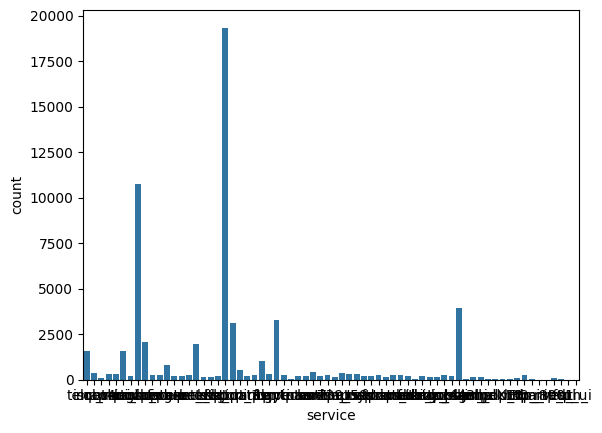

In [ ]:
for col in cat_cols:
    sns.countplot(x=col, data=df)
    plt.show()

In [ ]:
df.columns

Index(['logged_in', 'dst_host_same_srv_rate', 'wrong_fragment',
       'same_srv_rate', 'srv_diff_host_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_count', 'count',
       'rerror_rate', 'dst_host_serror_rate', 'srv_serror_rate',
       'dst_host_count', 'dst_host_srv_serror_rate',
       'dst_host_srv_rerror_rate', 'serror_rate', 'Label',
       'dst_host_diff_srv_rate', 'service', 'diff_srv_rate',
       'srv_rerror_rate'],
      dtype='object')

In [ ]:
# VERSION ANTIGUA
# %%script false
# Preprocesamiento de datos

le = LabelEncoder()
X_categorical = X.select_dtypes(include=['object'])
X_categorical = X_categorical.apply(le.fit_transform)

scaler = StandardScaler()
X_numeric = X.select_dtypes(include=['int64', 'float64'])
X_numeric_scaled = scaler.fit_transform(X_numeric)
X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=X_numeric.columns)

X_categorical.reset_index(drop=True, inplace=True)
X_numeric_scaled.reset_index(drop=True, inplace=True)

# Recombinar variables
X = pd.concat([X_numeric_scaled, X_categorical], axis=1)

Depuración de los datos, tratamiento de variables categóricas y normalización de los datos. La decision sobre el tipo de codificacion a usar, sigue siendo la misma que hasta ahora. si la variable categórica tiene pocos valores únicos, se puede usar one-hot encoding; si la variable categórica tiene muchos valores únicos, se puede usar label encoding o frequency encoding.

IMPORTANTE: En cuales quiera de las dos opciones, siempre se modificara el estado de la variable `df` para evitar sobrecargar la memoria.

In [ ]:
one_hot_encoded = pd.get_dummies(df['srcip'], drop_first=True)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(['srcip'], axis=1, inplace=True)

In [ ]:
#df = target_encode(df, ['proto', 'state'], 'Label')
df = target_encode(df, ['service'], 'Label')

In [ ]:
raw_df.head()

,dmeansz,ct_state_ttl,srcip,proto,dwin,Dload,ct_src_dport_ltm,tcprtt,swin,Sjit,ct_dst_ltm,Sload,ct_dst_src_ltm,state,Dpkts,Spkts,sttl,ct_dst_sport_ltm,Label
0,89,0,Japan,udp,0,7.221095e+05,1,0.000000,0,0.000000,6,5.922921e+05,2,CON,2,2,31,1,0
1,53,0,Japan,tcp,255,5.550936e+04,1,0.008268,255,245.278645,7,1.723701e+06,4,FIN,6,14,31,1,0
2,81,0,Japan,udp,0,6.315789e+05,1,0.000000,0,0.000000,6,5.068226e+05,1,CON,2,2,31,1,0
3,188,0,Japan,tcp,255,2.936404e+06,2,0.000685,255,26.861513,1,1.383171e+06,1,FIN,12,12,31,1,0
4,82,0,Japan,tcp,255,2.965331e+05,2,0.000615,255,161.021453,6,3.624738e+05,1,FIN,10,8,31,1,0


In [ ]:
scaler = StandardScaler()

df_scaled_features = scaler.fit_transform(df.drop('Label', axis=1))
df[df.drop('Label', axis=1).columns] = df_scaled_features

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [ ]:
X = df.drop('Label', axis=1)
y = df['Label']

# Dividir datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59406 entries, 131742 to 17425
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   logged_in                    59406 non-null  float64
 1   dst_host_same_srv_rate       59406 non-null  float64
 2   wrong_fragment               59406 non-null  float64
 3   same_srv_rate                59406 non-null  float64
 4   srv_diff_host_rate           59406 non-null  float64
 5   dst_host_rerror_rate         59406 non-null  float64
 6   dst_host_same_src_port_rate  59406 non-null  float64
 7   dst_host_srv_count           59406 non-null  float64
 8   count                        59406 non-null  float64
 9   rerror_rate                  59406 non-null  float64
 10  dst_host_serror_rate         59406 non-null  float64
 11  srv_serror_rate              59406 non-null  float64
 12  dst_host_count               59406 non-null  float64
 13  dst_host_srv_ser

Selección de hiperparámetros

In [ ]:
from sklearn.metrics import f1_score, make_scorer

f1_weighted = make_scorer(f1_score, average='weighted')

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, len(X_train.columns), 5),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar el clasificador de árbol de decisión
clf = DecisionTreeClassifier(
    class_weight='balanced'
)

# Inicializar GridSearchCV con validación cruzada de 5 pliegues
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=1000,
    cv=3,
    n_jobs=-1,
    scoring=f1_weighted,
    return_train_score=True,
    verbose=5
)

# Ajustar GridSearchCV a los datos de entrenamiento
random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 72 candidates, totalling 216 fits


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced'),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 20, 5),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=weighted), verbose=5)

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df.to_csv(f'./drive/MyDrive/{dataset_name}/results/DecTree/hyperparameters_results.csv', header=True, index=False)

In [ ]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.149848,0.002296,0.240644,0.001973,2,1,1,gini,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.853369,0.848947,0.850363,0.850893,0.001843,55,0.849656,0.851867,0.851161,0.850895,0.000922
1,0.150011,0.003334,0.245636,0.004858,5,1,1,gini,"{'min_samples_split': 5, 'min_samples_leaf': 1...",0.853369,0.848947,0.850363,0.850893,0.001843,55,0.849656,0.851867,0.851161,0.850895,0.000922
2,0.154391,0.008916,0.243660,0.000320,10,1,1,gini,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.853369,0.848947,0.850363,0.850893,0.001843,55,0.849656,0.851867,0.851161,0.850895,0.000922
3,0.157122,0.012822,0.245556,0.002868,2,2,1,gini,"{'min_samples_split': 2, 'min_samples_leaf': 2...",0.853369,0.848947,0.850363,0.850893,0.001843,55,0.849656,0.851867,0.851161,0.850895,0.000922
4,0.219673,0.055762,0.264192,0.024989,5,2,1,gini,"{'min_samples_split': 5, 'min_samples_leaf': 2...",0.853369,0.848947,0.850363,0.850893,0.001843,55,0.849656,0.851867,0.851161,0.850895,0.000922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.353638,0.108397,0.352999,0.055519,5,2,16,entropy,"{'min_samples_split': 5, 'min_samples_leaf': 2...",0.980794,0.979339,0.981197,0.980444,0.000798,8,0.993396,0.993355,0.993558,0.993436,0.000088
68,0.414158,0.067815,0.422621,0.028480,10,2,16,entropy,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.982981,0.981202,0.980791,0.981658,0.000951,2,0.991613,0.991938,0.991978,0.991843,0.000163
69,0.495050,0.007988,0.417862,0.097309,2,4,16,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 4...",0.981606,0.980800,0.979412,0.980606,0.000906,6,0.990478,0.990642,0.991005,0.990708,0.000220
70,0.260165,0.007041,0.244988,0.002286,5,4,16,entropy,"{'min_samples_split': 5, 'min_samples_leaf': 4...",0.981527,0.980557,0.979250,0.980445,0.000933,7,0.990478,0.990601,0.991005,0.990695,0.000225


* Se ha tenido que añadir la definicion de la métrica de puntuación para aliviar el posible efecto de datasets desbalanceados.







In [ ]:
# Obtener los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evaluar el modelo con los mejores hiperparámetros en los datos de prueba
accuracy = random_search.score(
    X_test,
    y_test)
print("Exactitud del modelo con mejores hiperparámetros:", accuracy)

Mejores hiperparámetros: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 16, 'criterion': 'entropy'}
Exactitud del modelo con mejores hiperparámetros: 0.9858618364802291


In [ ]:
df.drop('Label', axis=1).info()

In [ ]:
best_model = random_search.best_estimator_
best_tree = best_model.tree_
resultados = pd.DataFrame(random_search.cv_results_)

results_dir = f"./drive/MyDrive/{dataset_name}/results/DecTree/"
os.makedirs(results_dir, exist_ok=True)

# Guardar el modelo entrenado y los hiperparámetros
model_filename = os.path.join(results_dir, "mejor_modelo_entrenado.pkl")
joblib.dump(best_model, model_filename)

params_filename = os.path.join(results_dir, "mejores_hiperparametros.txt")
with open(params_filename, 'w') as f:
    f.write("Mejores hiperparámetros:\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")

print("Resultados de la búsqueda de hiperparámetros y árbol de decisión guardados en el directorio:", results_dir)

Resultados de la búsqueda de hiperparámetros y árbol de decisión guardados en el directorio: ./drive/MyDrive/nsl-kdd/results/DecTree/


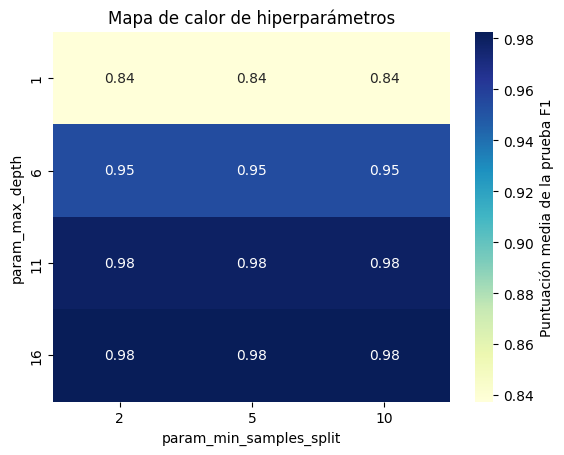

In [ ]:
import matplotlib.pyplot as plt

# Crear un mapa de calor de los resultados
resultados_grouped = resultados.groupby(['param_max_depth', 'param_min_samples_split'])['mean_test_score'].mean().reset_index()
resultados_pivot = resultados_grouped.pivot(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score')

plt.figure()
sns.heatmap(resultados_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Puntuación media de la prueba F1'})
plt.title('Mapa de calor de hiperparámetros')

plt.show()

In [ ]:
train_scores = {}
test_scores = {}

# Iterar sobre los hiperparámetros y sus valores
for param, param_values in param_grid.items():
    train_scores[param] = []
    test_scores[param] = []
    for value in param_values:
        # Filtrar los resultados para el valor actual del hiperparámetro
        mask = resultados['param_' + param] == value

        # Calcular la media de los puntajes de entrenamiento y prueba para el valor actual del hiperparámetro
        train_score_mean = resultados[mask]['mean_train_score'].mean()
        test_score_mean = resultados[mask]['mean_test_score'].mean()

        # Almacenar los puntajes medios en los diccionarios
        train_scores[param].append(train_score_mean)
        test_scores[param].append(test_score_mean)


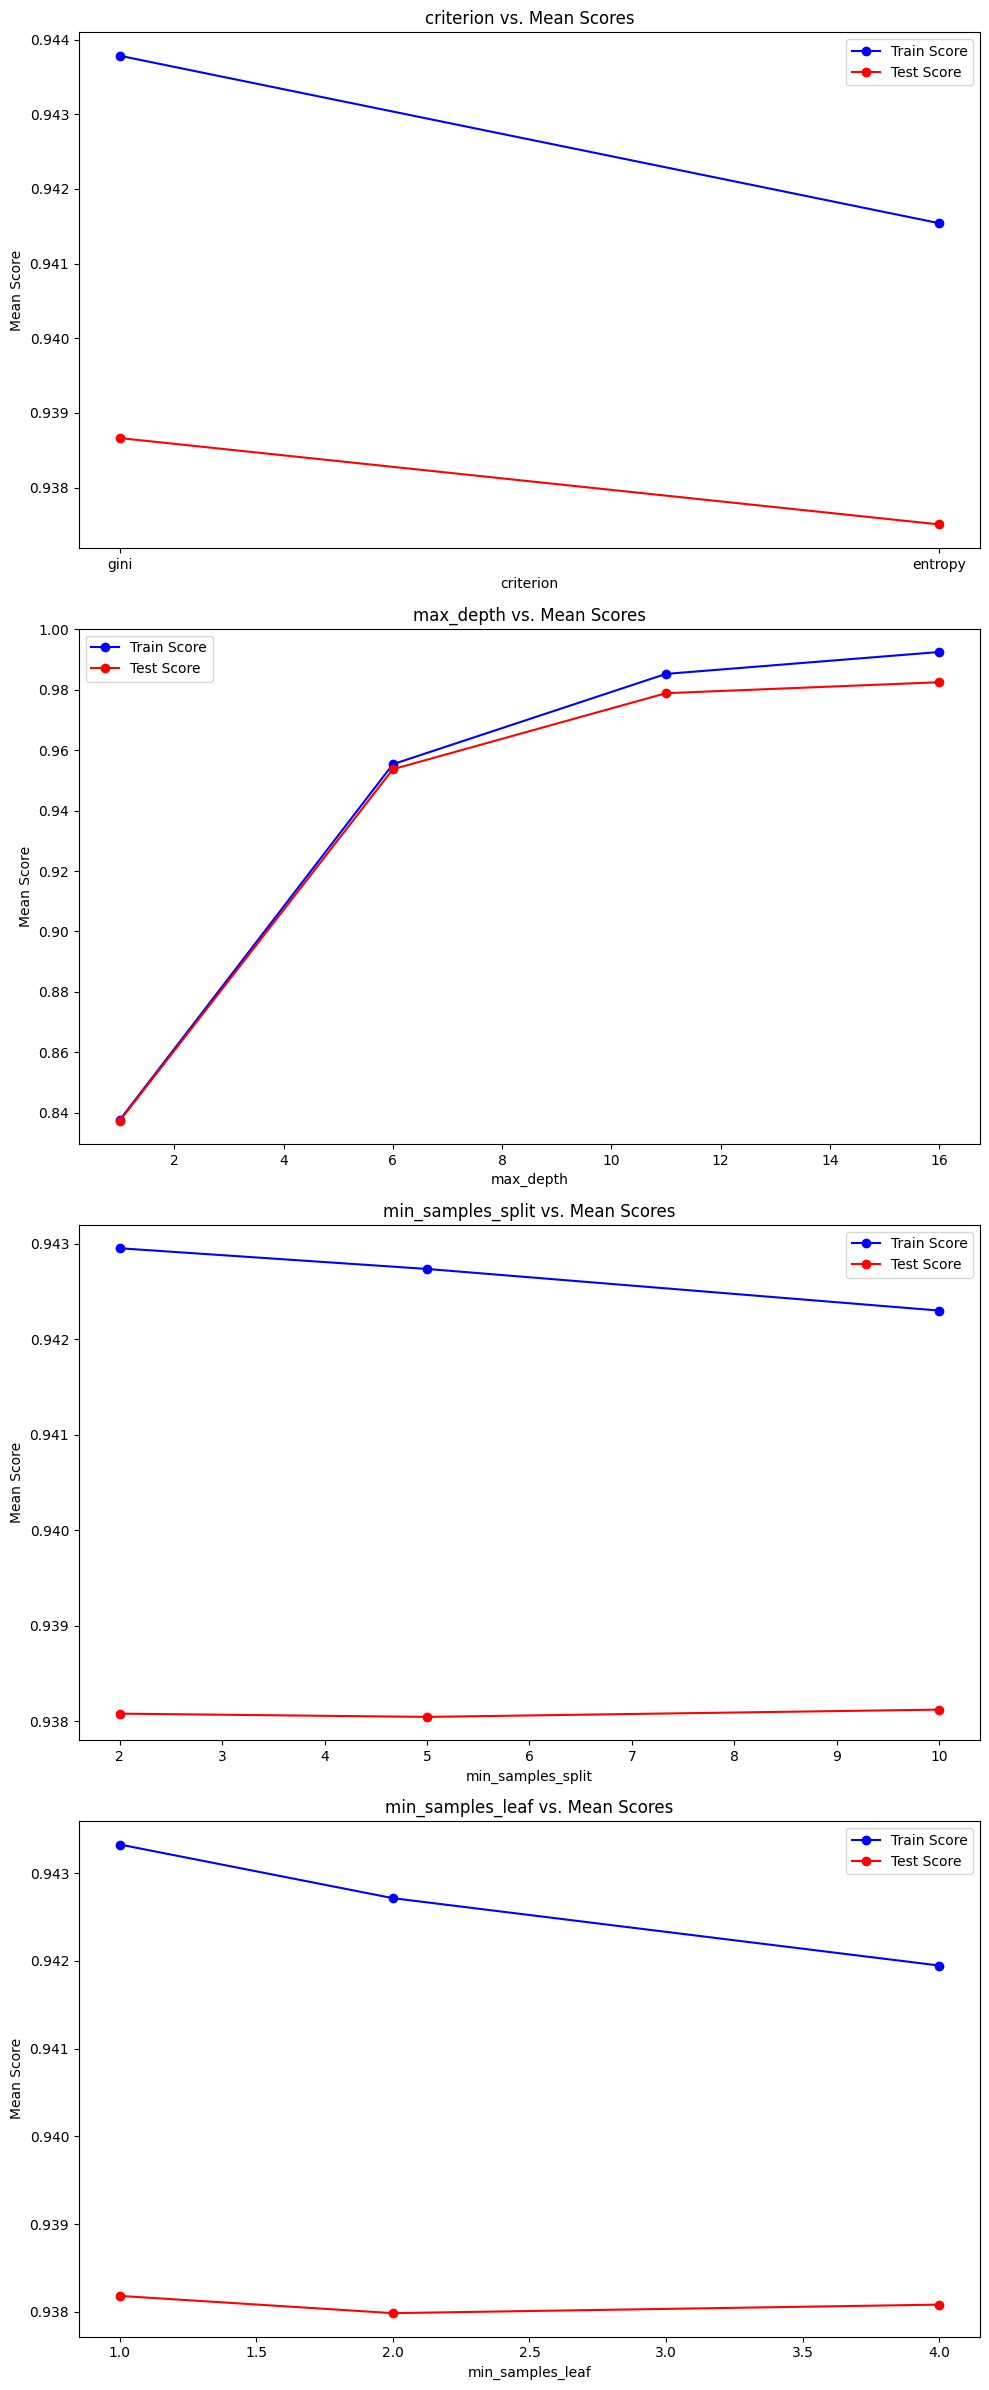

In [ ]:
# Crear subgráficos para cada hiperparámetro
num_subplots = len(train_scores)

# Definir colores para los trazos
colors = ['blue', 'red', 'green', 'orange']

fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

# Iterar sobre los hiperparámetros y sus valores
for i, (param, values) in enumerate(train_scores.items()):
    ax = axes[i]
    ax.plot(param_grid[param], train_scores[param], color='blue', marker='o', label='Train Score')
    ax.plot(param_grid[param], test_scores[param], color='red', marker='o', label='Test Score')
    ax.set_title(f'{param} vs. Mean Scores')
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Score')
    ax.legend()

plt.tight_layout()
plt.show()

Después de la búsqueda, junto con la información recogida en las gŕaficas, resulta interesante elegir otros valores de hiperparámetros, que aunque con menor puntuación, dan lugar a modelos con menos complejidad con una mayor adaptabilidad a nuevos datos:
  + cse-cic: {criterion: entropy, maxdepth:6, min_sample_split:6, min_sample_leaf:4}

**Métricas de rendimiento**


Reporte de clasificación en datos de prueba:
              precision    recall  f1-score   support

     anomaly       0.96      0.93      0.94      5691
      normal       0.94      0.96      0.95      6191

    accuracy                           0.95     11882
   macro avg       0.95      0.95      0.95     11882
weighted avg       0.95      0.95      0.95     11882



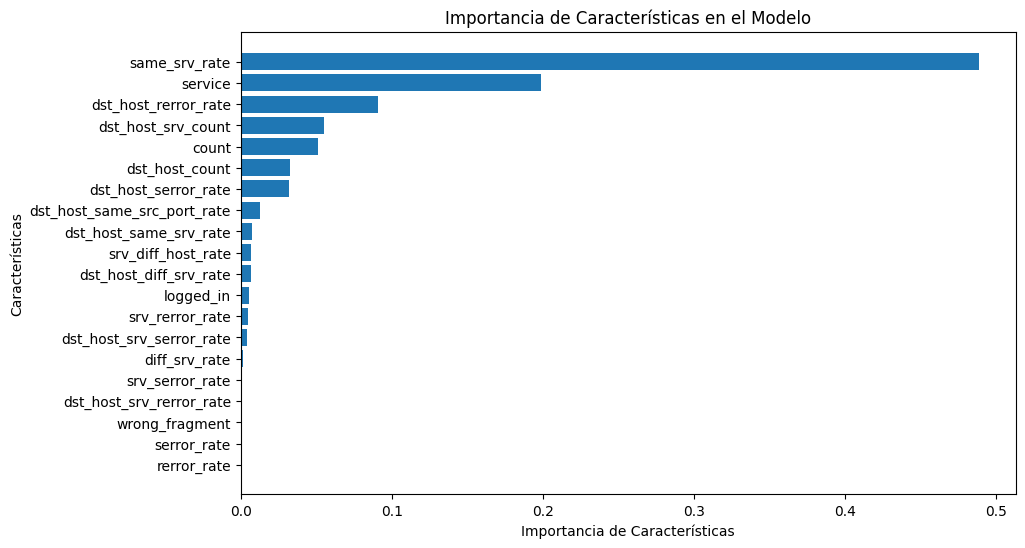

In [ ]:
y_pred_test = clf.predict(X_test)
y_proba_test = clf.predict_proba(X_test)[:, 1]

print("\nReporte de clasificación en datos de prueba:")
print(classification_report(y_test, y_pred_test))
# Importancia de las características
feature_importance = clf.feature_importances_
sorted_indices = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importance[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [X_train.columns[i] for i in sorted_indices])
plt.xlabel('Importancia de Características')
plt.ylabel('Características')
plt.title('Importancia de Características en el Modelo')
plt.show()

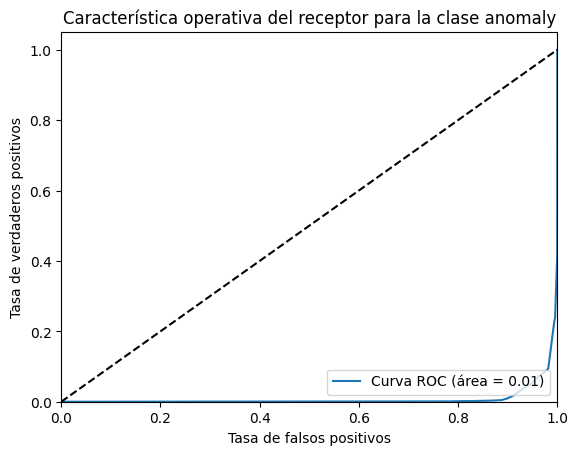

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=np.unique(y.values))
y_score = clf.predict_proba(X_test)
n_classes = y_test_bin.shape[1]
class_labels = np.unique(y.values)  # Obtener las etiquetas de clase únicas

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular la curva ROC y el AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crear una gráfica separada para cada clase
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='Curva ROC (área = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Característica operativa del receptor para la clase %s' % class_labels[i])
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

# Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


NameError: name 'roc_curve' is not defined

In [ ]:
# Asume que class_labels es una lista de tus etiquetas de clase
class_labels = y.values

# Calcula la matriz de confusión y la muestra
matriz_confusion = confusion_matrix(y_test, y_pred_test)
plt.figure()
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

### Medici'on de Rendimiento

In [ ]:
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# CSE - CIC 2018
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

In [ ]:
# UNSW NB15
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=11,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

In [ ]:
# NSL - KDD
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=11,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

In [ ]:
# Medir el tiempo de entrenamiento
start_time_train = time.time()
clf.fit(X_train, y_train)
end_time_train = time.time()
training_time = end_time_train - start_time_train

# Medir el tiempo de predicción
start_time_pred = time.time()
y_pred = clf.predict(X_test)
end_time_pred = time.time()
prediction_time = end_time_pred - start_time_pred

# Calcular métricas de rendimiento
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Número de observaciones
num_train_obs = X_train.shape[0]
num_test_obs = X_test.shape[0]



In [ ]:
# Resultados formales CSE CIC 2018
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 7.471740558338404e-06 segundos
Tiempo de predicción: 3.538894622085585e-07 segundos
Número de observaciones de entrenamiento: 24794
Número de observaciones de prueba: 12213
Precisión (weighted): 0.9781
Recall (weighted): 0.9781
F1 Score (weighted): 0.9781



In [ ]:
# Resultados formales NSL KDD
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 7.471740558338404e-06 segundos
Tiempo de predicción: 3.538894622085585e-07 segundos
Número de observaciones de entrenamiento: 24794
Número de observaciones de prueba: 12213
Precisión (weighted): 0.9781
Recall (weighted): 0.9781
F1 Score (weighted): 0.9781



In [ ]:
# Resultados formales UNSW NB15
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 4.143833048520526e-06 segundos
Tiempo de predicción: 1.4972827798186397e-07 segundos
Número de observaciones de entrenamiento: 1219218
Número de observaciones de prueba: 406407
Precisión (weighted): 0.9886
Recall (weighted): 0.9875
F1 Score (weighted): 0.9877



## Random Forest

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def target_encode(df, cat_columns, target_column, alpha=1):
    # Verificar si las columnas categóricas están presentes en el DataFrame
    missing_columns = [col for col in cat_columns if col not in df.columns]
    if missing_columns:
        print(f"Advertencia: Las siguientes columnas categóricas están ausentes en el DataFrame: {', '.join(missing_columns)}")
        cat_columns = [col for col in cat_columns if col not in missing_columns]

    # Realizar codificación manual en la columna objetivo si no es numérica
    if not np.issubdtype(df[target_column].dtype, np.number):
        target_encoded = df[target_column].map({'anomaly': 1, 'normal': 0})
    else:
        target_encoded = df[target_column]

    for col in cat_columns:
        freq = df[col].value_counts(normalize=True)
        try:
            mean_target = df.groupby(col).apply(lambda group: target_encoded[group.index].mean())
            sample_size = df.shape[0]

            encoded_values = (freq * mean_target + alpha) / (freq + alpha * sample_size)
            encoding_map = dict(zip(encoded_values.index, encoded_values.values))

            df[col] = df[col].map(encoding_map)
        except Exception as e:
            print(f"Advertencia: No se pudo codificar la columna '{col}' debido al error: {str(e)}")

    return df

In [ ]:
dataset_name = 'cse-cic'

raw_df = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/{dataset_name}.csv')
df = raw_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=0.4))

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

cat_cols = raw_df.drop('Label', axis=1).select_dtypes(include=['object'])

for col in cat_cols:
    sns.countplot(x=col, data=df)
    plt.show()

Para determinar qué tipo de codificación usar, se seguirá el siguiente criterio: si la variable categórica tiene pocos valores únicos, se puede usar one-hot encoding; si la variable categórica tiene muchos valores únicos, se puede usar label encoding o frequency encoding.

IMPORTANTE: En cuales quiera de las dos opciones, siempre se modificara el estado de la variable `df` para evitar sobrecargar la memoria.


In [ ]:
df.describe()

In [ ]:
one_hot_encoded = pd.get_dummies(df['srcip'], drop_first=True)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(['srcip'], axis=1, inplace=True)

In [ ]:
#df = target_encode(df, ['proto', 'state'], 'Label')
df = target_encode(df, ['service'], 'Label')

In [ ]:
scaler = StandardScaler()

df_scaled_features = scaler.fit_transform(df.drop('Label', axis=1))
df[df.drop('Label', axis=1).columns] = df_scaled_features

In [ ]:
df.reset_index()

X = df.drop('Label', axis=1)
y = df['Label']


# Dividir los índices en conjuntos de entrenamiento y prueba
indices_train, indices_test = train_test_split(df.index, test_size=0.25, random_state=42)

# Utilizar los índices para seleccionar los datos correspondientes
X_train, X_test = X.loc[indices_train], X.loc[indices_test]
y_train, y_test = y.loc[indices_train], y.loc[indices_test]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    stratify=y,
)



param_dist = {
    'n_estimators': [100, 150, 200],
    'max_leaf_nodes': [None, 10, 20],
    'max_samples': [None, 0.5, 0.7],
    'min_samples_split': [2, 5, 10]
}

-> Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 2, 'max_samples': 0.7, 'max_leaf_nodes': None}
Exactitud del modelo con mejores hiperparámetros: 0.977243726074011

In [ ]:
from sklearn.metrics import f1_score, make_scorer

rf_classifier = RandomForestClassifier(
    class_weight='balanced'
)

n_features = X.shape[1]  # Número de características
n_samples = X.shape[0]  # Número de muestras

f1_weighted = make_scorer(f1_score, average='weighted')

param_dist = {
     'n_estimators': [100, 150, 200, 300, 400],
     'max_depth':[6, 9, 11],
     'criterion':['entropy', 'gini']
}

random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    scoring=f1_weighted,
    param_distributions=param_dist,
    n_iter=750,
    cv=2,
    n_jobs=-1,
    return_train_score=True,
    verbose=3
)

In [ ]:
classifier = RandomForestClassifier(
     n_estimators=450,
     max_depth=16,
     criterion='entropy'
)

classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=450)

In [ ]:
 random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=750. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 30 candidates, totalling 60 fits


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=750, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [6, 9, 11],
                                        'n_estimators': [100, 150, 200, 300,
                                                         400]},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df.to_csv(f'./drive/MyDrive/{dataset_name}/results/RandomForest/hyperparameters_results.csv', header=True, index=False)

In [ ]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,1.612269,0.022657,0.554699,0.013959,100,6,entropy,"{'n_estimators': 100, 'max_depth': 6, 'criteri...",0.950416,0.945884,0.948150,0.002266,21,0.953000,0.947550,0.950275,0.002725
1,2.270873,0.015424,0.980166,0.022755,150,6,entropy,"{'n_estimators': 150, 'max_depth': 6, 'criteri...",0.946975,0.945425,0.946200,0.000775,24,0.949328,0.947320,0.948324,0.001004
2,5.303118,0.076550,0.779624,0.010542,200,6,entropy,"{'n_estimators': 200, 'max_depth': 6, 'criteri...",0.943704,0.944048,0.943876,0.000172,28,0.946403,0.946001,0.946202,0.000201
3,4.414406,0.027526,0.931791,0.009288,300,6,entropy,"{'n_estimators': 300, 'max_depth': 6, 'criteri...",0.944852,0.945999,0.945425,0.000573,27,0.947781,0.947320,0.947551,0.000230
4,8.890500,0.061046,1.351087,0.004035,400,6,entropy,"{'n_estimators': 400, 'max_depth': 6, 'criteri...",0.945942,0.945539,0.945741,0.000201,26,0.948641,0.947722,0.948182,0.000459
5,1.788796,0.000209,0.631791,0.007994,100,9,entropy,"{'n_estimators': 100, 'max_depth': 9, 'criteri...",0.972611,0.976571,0.974591,0.001980,14,0.978361,0.980314,0.979338,0.000976
6,2.692957,0.021759,0.786101,0.003981,150,9,entropy,"{'n_estimators': 150, 'max_depth': 9, 'criteri...",0.973817,0.975825,0.974821,0.001004,12,0.980890,0.980144,0.980517,0.000373
7,5.535553,0.079008,1.578391,0.002128,200,9,entropy,"{'n_estimators': 200, 'max_depth': 9, 'criteri...",0.972322,0.976343,0.974332,0.002010,16,0.978820,0.980776,0.979798,0.000978
8,5.214047,0.003442,1.094040,0.021601,300,9,entropy,"{'n_estimators': 300, 'max_depth': 9, 'criteri...",0.972898,0.976229,0.974564,0.001666,15,0.979167,0.980086,0.979626,0.000460
9,9.919220,0.033596,1.291203,0.008526,400,9,entropy,"{'n_estimators': 400, 'max_depth': 9, 'criteri...",0.972552,0.976975,0.974763,0.002212,13,0.979108,0.981464,0.980286,0.001178


In [ ]:
best_model = random_search.best_estimator_
resultados = pd.DataFrame(random_search.cv_results_)

print("Mejores hiperparámetros:", random_search.best_params_)

accuracy = best_model.score(X_test, y_test)
print("Exactitud del modelo con mejores hiperparámetros:", accuracy)

import os
import joblib

results_dir = f"./drive/MyDrive/{dataset_name}/results/RandomForest/"
os.makedirs(results_dir, exist_ok=True)

# Guardar el modelo entrenado y los hiperparámetros
model_filename = os.path.join(results_dir, "mejor_modelo_entrenado.pkl")
joblib.dump(best_model, model_filename)

params_filename = os.path.join(results_dir, "mejores_hiperparametros.txt")
with open(params_filename, 'w') as f:
    f.write("Mejores hiperparámetros:\n")
    for param, value in random_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Resultados de la búsqueda de hiperparámetros y RandomForest guardados en el directorio:", results_dir)

Mejores hiperparámetros: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_depth': 16, 'criterion': 'entropy'}
Exactitud del modelo con mejores hiperparámetros: 0.9909776461082682
Resultados de la búsqueda de hiperparámetros y RandomForest guardados en el directorio: ./drive/MyDrive/nsl-kdd/results/RandomForest/


In [ ]:
resultados.to_csv(os.path.join(results_dir, 'resultados_busqueda.csv'), header=True, index=False)

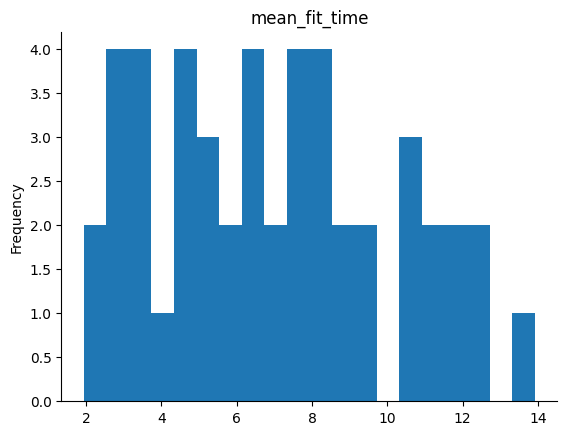

In [ ]:
from matplotlib import pyplot as plt
resultados['mean_fit_time'].plot(kind='hist', bins=20, title='mean_fit_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train_scores = {}
test_scores = {}

# Iterar sobre los hiperparámetros y sus valores
for param, param_values in param_dist.items():
    train_scores[param] = []
    test_scores[param] = []
    for value in param_values:
        # Filtrar los resultados para el valor actual del hiperparámetro
        mask = resultados['param_' + param] == value

        # Calcular la media de los puntajes de entrenamiento y prueba para el valor actual del hiperparámetro
        train_score_mean = resultados[mask]['mean_train_score'].mean()
        test_score_mean = resultados[mask]['mean_test_score'].mean()

        # Almacenar los puntajes medios en los diccionarios
        train_scores[param].append(train_score_mean)
        test_scores[param].append(test_score_mean)


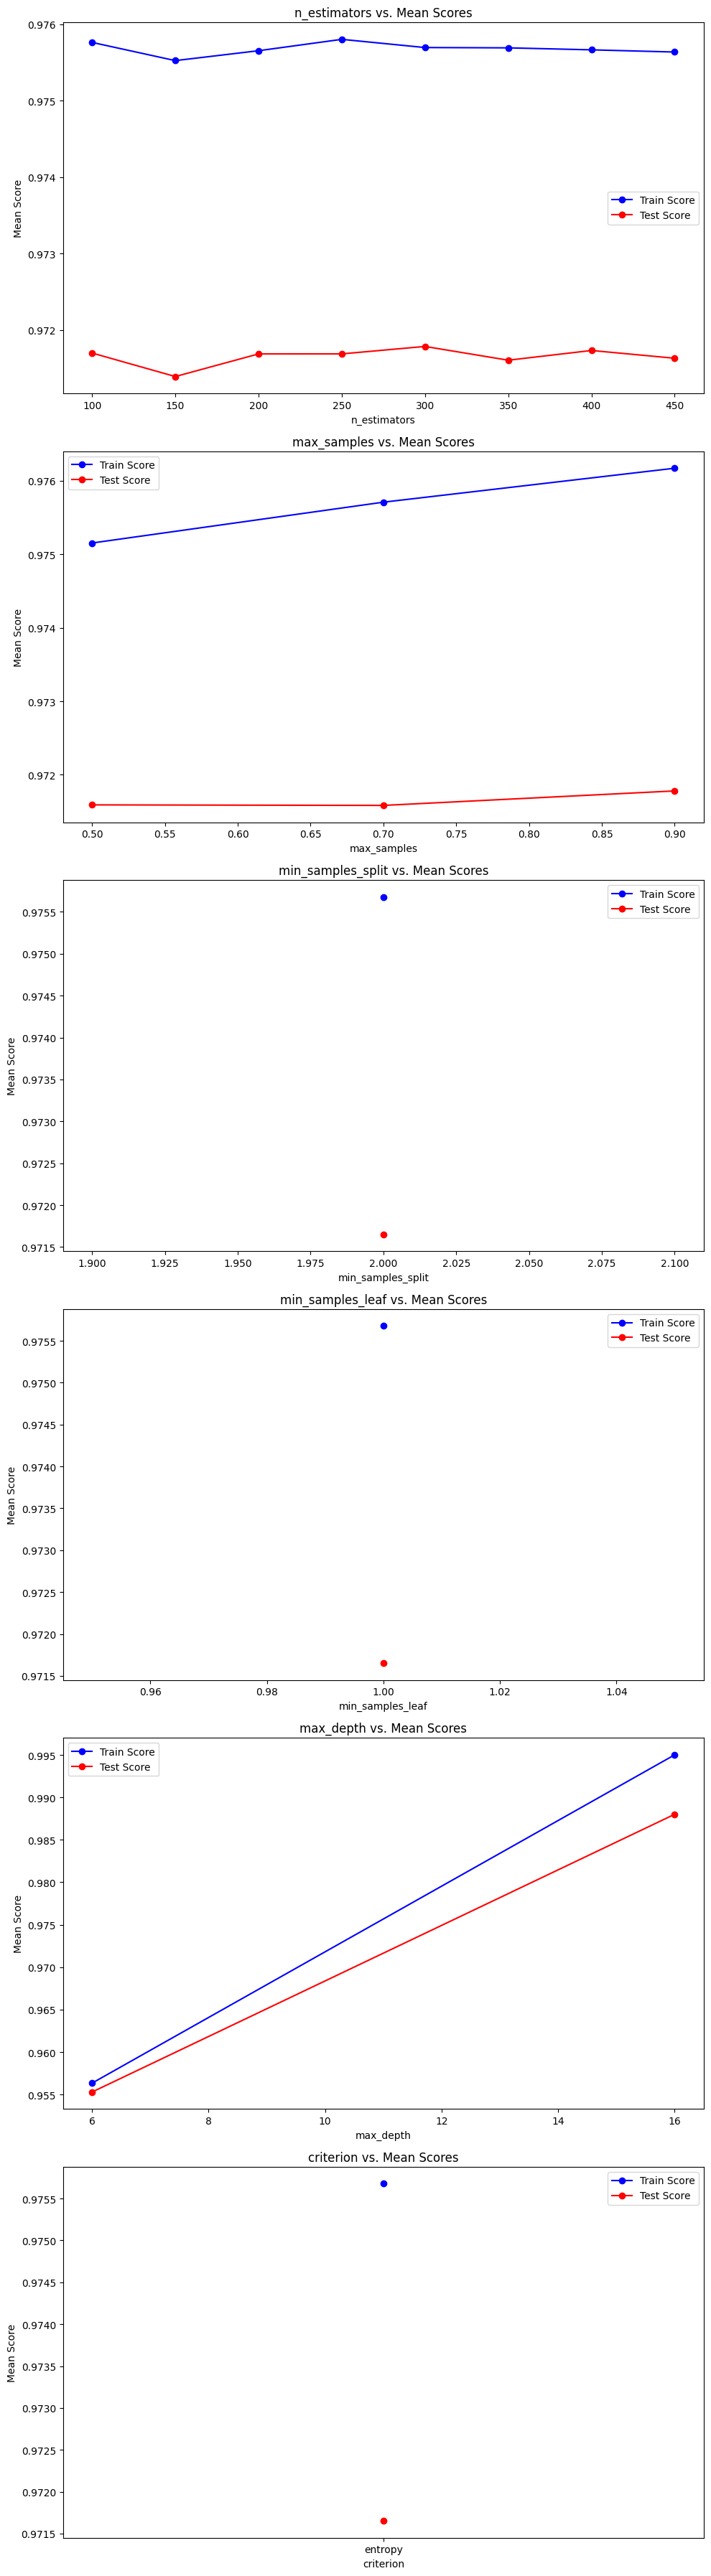

In [ ]:
# Crear subgráficos para cada hiperparámetro
num_subplots = len(train_scores)

# Definir colores para los trazos
colors = ['blue', 'red', 'green', 'orange']

fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

# Iterar sobre los hiperparámetros y sus valores
for i, (param, values) in enumerate(train_scores.items()):
    ax = axes[i]
    ax.plot(param_dist[param], train_scores[param], color='blue', marker='o', label='Train Score')
    ax.plot(param_dist[param], test_scores[param], color='red', marker='o', label='Test Score')
    ax.set_title(f'{param} vs. Mean Scores')
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Score')
    ax.legend()

plt.tight_layout()
plt.show()

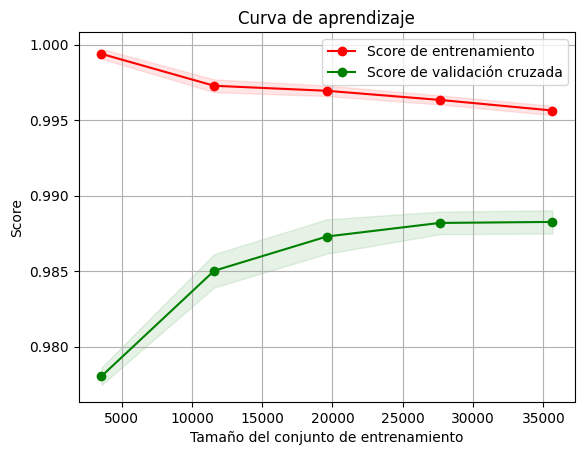


Reporte de clasificación en datos de prueba:
              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      7120
      normal       0.99      0.99      0.99      7732

    accuracy                           0.99     14852
   macro avg       0.99      0.99      0.99     14852
weighted avg       0.99      0.99      0.99     14852

Métricas de rendimiento del modelo en el conjunto de prueba:
Accuracy: 0.9914
Precision: 0.9935
Recall: 0.9885
F1-score: 0.9910


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

rf_clf = RandomForestClassifier(
     n_estimators=250,
     max_samples=0.9,
     min_samples_split=2,
     min_samples_leaf=1,
     max_depth=16,
     criterion='entropy'
)

rf_clf.fit(X_train, y_train)

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(rf_clf, X_train, y_train, cv=5)

# Calcular la media y la desviación estándar de los scores de entrenamiento y prueba
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Dibujar la curva de aprendizaje
plt.figure()
plt.title("Curva de aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación cruzada")

plt.legend(loc="best")
plt.show()

# Predicciones del modelo en el conjunto de datos completo
y_pred = rf_clf.predict(X_test)
y_proba_test = rf_clf.predict_proba(X_test)[:, 1]

print("\nReporte de clasificación en datos de prueba:")
print(classification_report(y_test, y_pred))


# Mapear las etiquetas a valores binarios
y_test_binary = y_test.map({'anomaly': 1, 'normal': 0})
y_pred_binary = pd.Series(y_pred).map({'anomaly': 1, 'normal': 0})

# Métricas de rendimiento
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
print("Métricas de rendimiento del modelo en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=np.unique(y.values))
y_score = clf.predict_proba(X_test)
n_classes = y_test_bin.shape[1]
class_labels = np.unique(y.values)  # Obtener las etiquetas de clase únicas

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular la curva ROC y el AUC para cada clase (multiclass)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crear una gráfica separada para cada clase
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='Curva ROC (área = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Característica operativa del receptor para la clase %s' % class_labels[i])
    plt.legend(loc="lower right")
    plt.show()

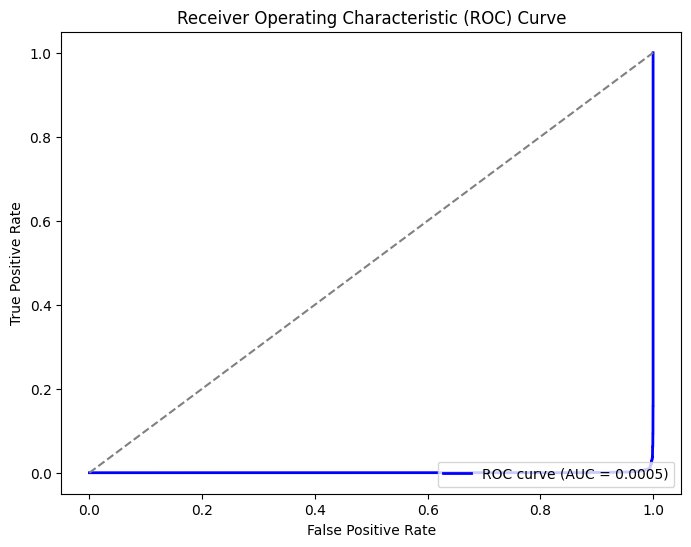

In [ ]:
rf_clf.fit(X_train, y_train)

# Curva ROC y valor AUC (binario)
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

y_test_binary = y_test.map({'anomaly': 1, 'normal': 0})
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
roc_auc = roc_auc_score(y_test_binary, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
class_labels = y.values

# Calcula la matriz de confusión y la muestra
matriz_confusion = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

### Medici'on de Rendimiento

In [ ]:
import time

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# CSE CIC
clf = RandomForestClassifier(
    n_estimators=150,
    criterion='entropy',
    max_depth=11,
    random_state=42
    )

In [ ]:
# NSL KDD
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=11, random_state=42)

In [ ]:
# UNSW NB15
clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=6, random_state=42)

In [ ]:
# Medir el tiempo de entrenamiento
start_time_train = time.time()
clf.fit(X_train, y_train)
end_time_train = time.time()
training_time = end_time_train - start_time_train

# Medir el tiempo de predicción
start_time_pred = time.time()
y_pred = clf.predict(X_test)
end_time_pred = time.time()
prediction_time = end_time_pred - start_time_pred

# Calcular métricas de rendimiento
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Número de observaciones
num_train_obs = X_train.shape[0]
num_test_obs = X_test.shape[0]

In [ ]:
# Resultados formales UNSW NB15
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

In [ ]:
# Resultados formales UNSW NB15
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

In [ ]:
# Resultados formales CSE CIC 2018
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 0.00026716244764258076 segundos
Tiempo de predicción: 2.5423403112998924e-05 segundos
Número de observaciones de entrenamiento: 272228
Número de observaciones de prueba: 90743
Precisión (weighted): 0.9644
Recall (weighted): 0.9772
F1 Score (weighted): 0.9667



In [ ]:
# Resultados formales NSL KDD
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 6.702075689619968e-05 segundos
Tiempo de predicción: 1.0316635265520571e-05 segundos
Número de observaciones de entrenamiento: 24794
Número de observaciones de prueba: 12213
Precisión (weighted): 0.9815
Recall (weighted): 0.9813
F1 Score (weighted): 0.9813



In [ ]:
# Resultados formales UNSW NB15
results = (
    f"Tiempo de entrenamiento: {training_time/num_train_obs} segundos\n"
    f"Tiempo de predicción: {prediction_time/num_test_obs} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Precisión (weighted): {precision:.4f}\n"
    f"Recall (weighted): {recall:.4f}\n"
    f"F1 Score (weighted): {f1:.4f}\n"
)

print(results)

Tiempo de entrenamiento: 0.00013096717932973743 segundos
Tiempo de predicción: 1.584426144120732e-05 segundos
Número de observaciones de entrenamiento: 1219218
Número de observaciones de prueba: 406407
Precisión (weighted): 0.9913
Recall (weighted): 0.9912
F1 Score (weighted): 0.9912



## Hyperparameter Impacts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

def plot_hyperparameter_impacts(random_search_cv: RandomizedSearchCV, save_route):
    cv_results = random_search_cv.cv_results_

    # Create a DataFrame from cv_results_
    results_df = pd.DataFrame(cv_results)
    results_df.to_csv(save_route, index=False, header=True)


    hyperparameters = [key for key in cv_results.keys() if key.startswith('param_')]


    plot_data = pd.DataFrame()
    for param in hyperparameters:
        # Extract relevant columns
        temp_df = results_df[[param, 'mean_test_score']].copy()
        temp_df.columns = ['Hyperparameter Value', 'Score']
        temp_df['Hyperparameter'] = param.replace('param_', '')
        plot_data = pd.concat([plot_data, temp_df], axis=0)


    plt.figure(figsize=(15, 10))
    sns.boxplot(x='Hyperparameter', y='Score', hue='Hyperparameter Value', data=plot_data)
    plt.title('Impact of Hyperparameter Values on Score')
    plt.xticks(rotation=45)
    plt.show()


# plot_hyperparameter_impacts(random_search)

In [ ]:
scores  = pd.read_csv(f'/content/drive/MyDrive/unsw-nb15/results/svm/hyperparameters_results.csv')
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       100 non-null    float64
 1   std_fit_time        100 non-null    float64
 2   mean_score_time     100 non-null    float64
 3   std_score_time      100 non-null    float64
 4   param_kernel        100 non-null    object 
 5   param_gamma         100 non-null    object 
 6   param_degree        100 non-null    int64  
 7   param_coef0         100 non-null    float64
 8   param_C             100 non-null    float64
 9   params              100 non-null    object 
 10  split0_test_score   100 non-null    float64
 11  split1_test_score   100 non-null    float64
 12  mean_test_score     100 non-null    float64
 13  std_test_score      100 non-null    float64
 14  rank_test_score     100 non-null    int64  
 15  split0_train_score  100 non-null    float64
 16  split1_tr

In [ ]:
scores_kernels.info(

) # (Kernel, C) -> mean_test_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       12 non-null     float64
 1   std_fit_time        12 non-null     float64
 2   mean_score_time     12 non-null     float64
 3   std_score_time      12 non-null     float64
 4   param_kernel        12 non-null     object 
 5   param_C             12 non-null     float64
 6   params              12 non-null     object 
 7   split0_test_score   12 non-null     float64
 8   split1_test_score   12 non-null     float64
 9   mean_test_score     12 non-null     float64
 10  std_test_score      12 non-null     float64
 11  rank_test_score     12 non-null     int64  
 12  split0_train_score  12 non-null     float64
 13  split1_train_score  12 non-null     float64
 14  mean_train_score    12 non-null     float64
 15  std_train_score     12 non-null     float64
dtypes: float64

In [ ]:
scores_linear.info() # (kernel,C) -> mean_test_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       5 non-null      float64
 1   std_fit_time        5 non-null      float64
 2   mean_score_time     5 non-null      float64
 3   std_score_time      5 non-null      float64
 4   param_kernel        5 non-null      object 
 5   param_C             5 non-null      float64
 6   params              5 non-null      object 
 7   split0_test_score   5 non-null      float64
 8   split1_test_score   5 non-null      float64
 9   mean_test_score     5 non-null      float64
 10  std_test_score      5 non-null      float64
 11  rank_test_score     5 non-null      int64  
 12  split0_train_score  5 non-null      float64
 13  split1_train_score  5 non-null      float64
 14  mean_train_score    5 non-null      float64
 15  std_train_score     5 non-null      float64
dtypes: float64(1

In [ ]:
scores_non_linear.info() # (kernnel, gamma, degree, coef0, C) -> mean_test_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       100 non-null    float64
 1   std_fit_time        100 non-null    float64
 2   mean_score_time     100 non-null    float64
 3   std_score_time      100 non-null    float64
 4   param_kernel        100 non-null    object 
 5   param_gamma         100 non-null    object 
 6   param_degree        100 non-null    int64  
 7   param_coef0         100 non-null    float64
 8   param_C             100 non-null    float64
 9   params              100 non-null    object 
 10  split0_test_score   100 non-null    float64
 11  split1_test_score   100 non-null    float64
 12  split2_test_score   100 non-null    float64
 13  split3_test_score   100 non-null    float64
 14  split4_test_score   100 non-null    float64
 15  mean_test_score     100 non-null    float64
 16  std_test_

<ipython-input-16-2951c0e73753>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'param_{hypar}', y='mean_test_score', data=scores, palette='viridis')


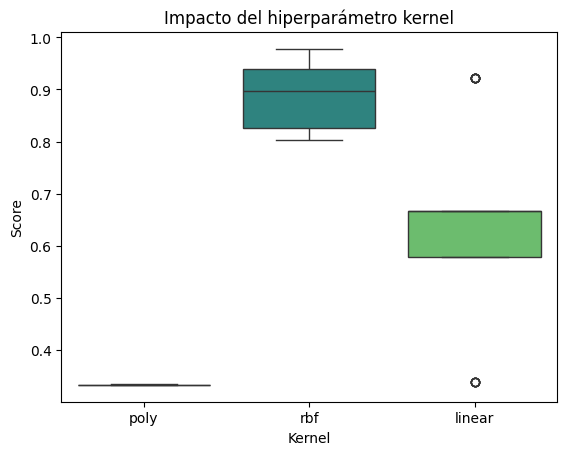

<ipython-input-16-2951c0e73753>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'param_{hypar}', y='mean_test_score', data=scores, palette='viridis')


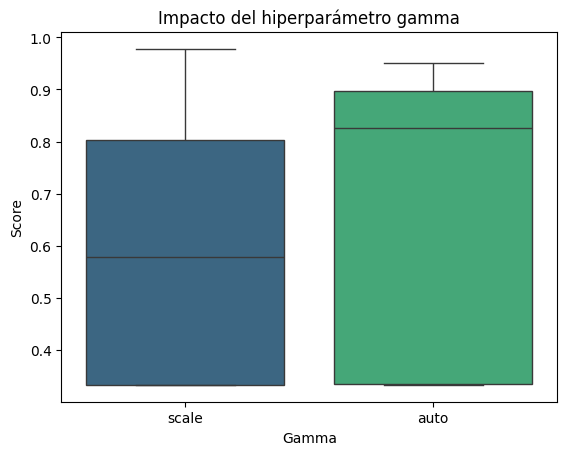

<ipython-input-16-2951c0e73753>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'param_{hypar}', y='mean_test_score', data=scores, palette='viridis')


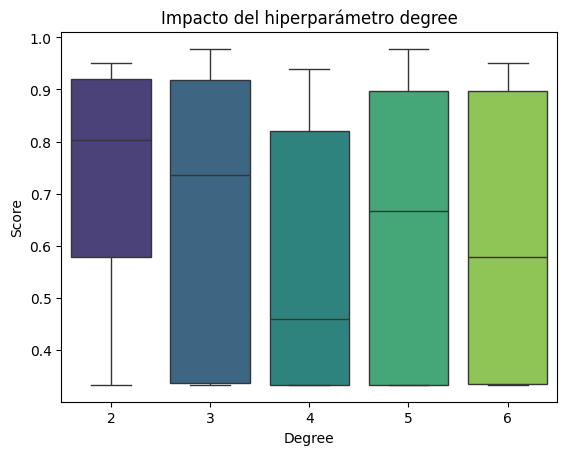

<ipython-input-16-2951c0e73753>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'param_{hypar}', y='mean_test_score', data=scores, palette='viridis')


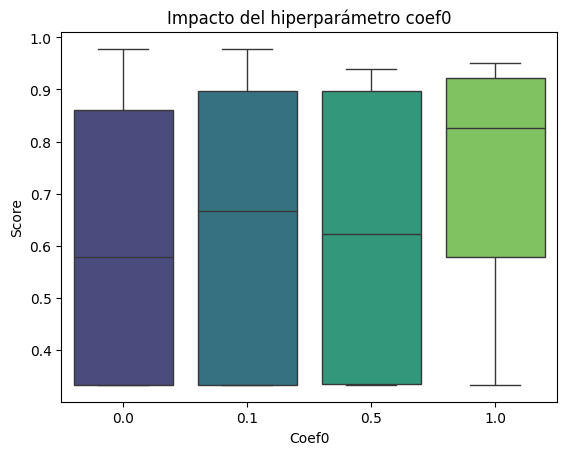

<ipython-input-16-2951c0e73753>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'param_{hypar}', y='mean_test_score', data=scores, palette='viridis')


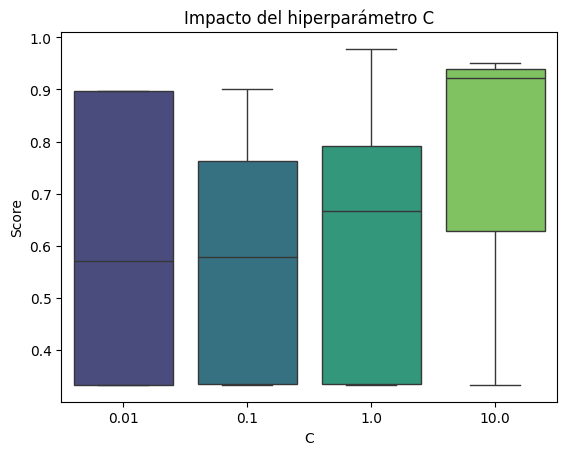

In [ ]:
params = ['kernel', 'gamma', 'degree','coef0','C']

for hypar in params:
  sns.boxplot(x=f'param_{hypar}', y='mean_test_score', data=scores, palette='viridis')
  plt.title(f'Impacto del hiperparámetro {hypar}')

  # Renombrar las etiquetas de los ejes: sustituir las _ por espacios en blanco y capitalizar texto
  plt.xlabel(hypar.replace('_', ' ').title())
  plt.ylabel('Score')
  plt.show()

In [ ]:
params = results_df['param_kernel']
scores = results_df['mean_test_score']

plot_df = pd.concat([params, scores], axis=1)

sns.boxplot(data=results_df, x='param_kernel', y='mean_test_score', palette='viridis')

NameError: name 'results_df' is not defined

# Deep Learning para AIDS

In [ ]:
import os
import json
import sys

import tensorflow as tf
import pandas as pd
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from typing import List, Union

from tensorflow.keras.layers import Layer, Dense, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2


def target_encode(df, cat_columns, target_column, alpha=1):
    encoding_maps = {}

    # Verificar si las columnas categóricas están presentes en el DataFrame
    missing_columns = [col for col in cat_columns if col not in df.columns]
    if missing_columns:
        print(f"Advertencia: Las siguientes columnas categóricas están ausentes en el DataFrame: {', '.join(missing_columns)}")
        cat_columns = [col for col in cat_columns if col not in missing_columns]

    # Realizar codificación manual en la columna objetivo si no es numérica
    if not np.issubdtype(df[target_column].dtype, np.number):
        target_encoded = df[target_column].map({'anomaly': 1, 'normal': 0})
    else:
        target_encoded = df[target_column]

    for col in cat_columns:
        freq = df[col].value_counts(normalize=True)
        try:
            mean_target = df.groupby(col).apply(lambda group: target_encoded[group.index].mean())
            sample_size = df.shape[0]

            encoded_values = (freq * mean_target + alpha) / (freq + alpha * sample_size)
            encoding_map = dict(zip(encoded_values.index, encoded_values.values))

            encoding_maps[col] = encoding_map
        except Exception as e:
            print(f"Advertencia: No se pudo codificar la columna '{col}' debido al error: {str(e)}")

    return encoding_maps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!du -h ./drive/MyDrive/nsl-kdd/*.csv

17M	./drive/MyDrive/nsl-kdd/a_KDDTrain+.csv
3.3M	./drive/MyDrive/nsl-kdd/KDDTest+.csv
17M	./drive/MyDrive/nsl-kdd/KDDTrain+.csv
20M	./drive/MyDrive/nsl-kdd/nsl-kdd.csv


In [ ]:
import pandas as pd


dataset_name = 'nsl-kdd'

raw_df = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/{dataset_name}.csv')

raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_df.dropna(inplace=True)
raw_df.reset_index(inplace=True)

df = raw_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=.4))

cat_cols = raw_df.drop('Label', axis=1).select_dtypes(include=['object'])
filename = f'./drive/MyDrive/{dataset_name}/results/freq_coder_dict.json'

# CSE CIC 2018 NO TIENE VARIABLES CATEGÓRICAS




freq_coder_dict = {}
if os.path.exists(filename):
    with open(filename, 'r') as f:
        freq_coder_dict = json.load(f)
else:
    #freq_coder_dict = target_encode(df, ['service'], 'Label') # PAra NSL KDD
    freq_coder_dict = target_encode(df, ['proto', 'state'], 'Label')
    # TODO: salvar el diccionario en el directorio para no volver a calcularlo
    with open(filename, 'w') as f:
      json.dump(freq_coder_dict, f)

#df.drop('index', axis=1, inplace=True)

"""
#X_train = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/X_train.csv')
#y_train = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/y_train.csv')
#X_test = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/X_train.csv')
#y_test = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/y_test.csv')
"""

"\n#X_train = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/X_train.csv')\n#y_train = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/y_train.csv')\n#X_test = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/X_train.csv')\n#y_test = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/y_test.csv')\n"

KeyError: "['index'] not found in axis"

In [ ]:
X = df.drop('Label', axis=1)
y = df['Label']
if not np.issubdtype(df['Label'].dtype, np.number):
  y = df['Label'].map({'anomaly': 1, 'normal': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    stratify=y
)

# Para cse-cic
#X_train_resampled, y_train_resampled = X_train, y_train

In [ ]:
X = df.drop('Label', axis=1)
y = df['Label']

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    stratify=y
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_test.shape

(11565, 2)

## Modelo propuesto

In [ ]:
# Y.N. Kunang et al. - Journal of Inforation Security And aplications 58 (2021) 102804
"""
Clase dedicada al preprocesing de los datos de la red neuronal:
    + Variables categóricas con muchos niveles -> Codificacion porfrecuencias
    + Variables categóricas con pocos niveles -> One HotEncoding
    + Escalado MinMax de los datos
"""
class CustomPreprocessingLayer(Layer):
    def __init__(self, one_hot_vars, freq_code_vars, freq_coder_dict, max_global=None, min_global=None):
        super(CustomPreprocessingLayer, self).__init__()
        self.one_hot_vars = one_hot_vars
        self.freq_code_vars = freq_code_vars
        self.freq_coder = freq_coder_dict
        self.scaler = MinMaxScaler()


    def adapt(self, X_test: pd.DataFrame):
        # Ajustar el escalador a los datos (solo a los valores núméricos, los categoricos serán procesados con el encoding)
        self.scaler.fit(X)

    def call(self, df: pd.DataFrame) -> tf.Tensor:
        if all(df[col].dtype.name == 'object' for col in self.one_hot_vars): # issubdtype
            print('Procediendo al one hot encoding')
            # One-hot
            for var in self.one_hot_vars:
                one_hot_encoded = pd.get_dummies(df[var], drop_first=True)
                df = pd.concat([df, one_hot_encoded], axis=1)
                df.drop([var], axis=1, inplace=True)

        # Target encode
        if all(df[etiqueta].dtype.name == 'object' for etiqueta in self.freq_code_vars):
            print('Procediendo a la codificacion por frecuencias')
            for col, enc_map in self.freq_coder.items():
                df[col] = df[col].map(enc_map)
        else:
            # excepción para notificar la sitación errónea
            print("El estado del dataset no es válido para la red neuronal. Algunas variables, que se esperaban categóricas, no lo son", file=sys.stderr)
            return df


        #self.scaler.fit(data.drop('Label', axis=1))  np.asarray(x).astype('float32')
        df_scaled_features = np.asarray(self.scaler.fit_transform(df)).astype('float32')

        # Adaptar datos para trabajar con tensores
        inputs_tensor = tf.convert_to_tensor(df_scaled_features, dtype=tf.float32)

        return inputs_tensor

class DAE_DNN_Model(tf.keras.Model):
    def __init__(self, input_dim, freq_dict, dae_dim, dnn_dims, learning_rate, kernel_initializer, batch_size, dropout_rate=0.5, l1_reg=0.01, l2_reg=0.01):
        super(DAE_DNN_Model, self).__init__()
        self.input_dim = input_dim
        self.freq_dict = freq_dict
        self.dae_dim = dae_dim
        self.dnn_dims = dnn_dims
        self.learning_rate = learning_rate
        self.kernel_initializer = kernel_initializer
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate

        self.trainning_mode = False

        # Definir la capa de pre-process
        self.preproces = CustomPreprocessingLayer([], ['service'], freq_dict)

        # capas del DAE
        self.encoder = Dense(
            self.dae_dim, activation='relu',
            kernel_initializer=self.kernel_initializer
            #kernel_regularizer=l1(l1_reg)
        )
        self.decoder = Dense(
            self.input_dim, activation='sigmoid',
            kernel_initializer=self.kernel_initializer
            #kernel_regularizer=l1(l1_reg)
        )

        # capas del DNN
        self.dnn_layers = [Dense(
                dim,
                activation='relu',
                kernel_initializer=self.kernel_initializer
                #kernel_regularizer=l2(l2_reg)
            ) for dim in self.dnn_dims]
        self.dropout_layers = [Dropout(self.dropout_rate) for _ in self.dnn_dims]
        self.output_layer = Dense(
            1,
            activation='sigmoid',
            kernel_initializer=self.kernel_initializer
            #kernel_regularizer=l2(l2_reg)
        )

    def call(self, inputs, training=False):
        if not inputs.dtype == tf.float32 : # [tensor.dtype == tf.float32 or pandas dataframe] -> prelayer
            print('Llamando a la capa de preprocessing desde el modelo')
            inputs = self.preproces(inputs)

        # Pasar los inputs a través del DAE
        inputs = self.encoder(inputs)
        #decoded = self.decoder(encoded)

        # Pasar la representación codificada (cuello de botella del DAE) a través del DNN
        x = inputs

        for dense_layer, dropout_layer in zip(self.dnn_layers, self.dropout_layers):
            x = dense_layer(x)
            #x = dropout_layer(x)  # Aplicar Dropout después de cada capa densa

        return self.output_layer(x)

    def compile_model(self):
        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def train_model(self, x_train: pd.DataFrame, y_train: pd.DataFrame, epochs):
        self.trainning_mode = True
        x_train = self.preproces(x_train)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        self.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_split=0.2,
            callbacks=[early_stopping]
        )
        self.trainning_mode = False

In [ ]:
# NSL KDD
nsl_kdd_hparams = {'learning_rate': 1e-06,
 'kernel_initializer': 'glorot_uniform',
 'l2_regularization': 0.0001,
 'num_hidden_layers': 5,
 'activations': 'relu',
 'encoder_nodes_0': 10,
 'encoder_nodes_1': 60,
 'encoder_nodes_2': 100,
 'encoder_nodes_3': 40,
 'encoder_nodes_4': 100,
 'classifier_num_layers': 1,
 'classifier_nodes_0': 30,
 'classifier_nodes_1': 40,
 'classifier_nodes_2': 70.0,
 'classifier_nodes_3': 30.0,
 'classifier_nodes_4': 20.0
 }

*   Dropout: Es una técnica de regularización que ayuda a prevenir el sobreajuste en las redes neuronales. Durante el entrenamiento, algunas neuronas de la red se "apagan" o se ignoran con una probabilidad definida por el valor de dropout. Esto significa que la red no puede depender demasiado de ninguna neurona individual, lo que a su vez significa que todas las neuronas deben contribuir para minimizar la pérdida. Un valor de dropout más alto significa que se ignoran más neuronas durante el entrenamiento, lo que puede ayudar a prevenir el sobreajuste, pero también puede llevar a un subajuste si el valor es demasiado alto.

* l1_reg: Es un tipo de regularización L1 (también conocida como regularización Lasso) que penaliza los pesos grandes en la red neuronal añadiendo a la función de pérdida un término proporcional a la suma absoluta de los pesos. Esto puede ayudar a prevenir el sobreajuste haciendo que la red sea más simple, ya que la regularización L1 tiende a producir "pesos dispersos" (muchos pesos son cero). Un valor de l1_reg más alto significa una penalización más fuerte para los pesos grandes, lo que puede hacer que la red sea más simple pero también puede llevar a un subajuste si el valor es demasiado alto.

* l2_reg: Es un tipo de regularización L2 (también conocida como regularización Ridge) que penaliza los pesos grandes en la red neuronal añadiendo a la función de pérdida un término proporcional al cuadrado de la suma de los pesos. Esto puede ayudar a prevenir el sobreajuste haciendo que la red sea más simple, ya que la regularización L2 tiende a producir "pesos pequeños" (todos los pesos son pequeños pero no necesariamente cero). Un valor de l2_reg más alto significa una penalización más fuerte para los pesos grandes, lo que puede hacer que la red sea más simple pero también puede llevar a un subajuste si el valor es demasiado alto.

In [ ]:
# CSE CIC IDS 2018
cse_cic_hparams = {
    'learning_rate': 0.01,
    'kernel_initializer': 'he_normal',
    'l2_regularization': 0.001,
    'num_hidden_layers': 3,

    'activations': 'elu',
    'classifier_num_layers': 4,

    'encoder_nodes_0': 60,
    'encoder_nodes_1': 40,
    'encoder_nodes_2': 30,
    'encoder_nodes_3': 20,
    'encoder_nodes_4': 100,
    'classifier_nodes_0': 80,
    'classifier_nodes_1': 40,
    'classifier_nodes_2': 90.0,
    'classifier_nodes_3': 30.0,
    'classifier_nodes_4': 30.0
}

In [ ]:
import numpy as np

unsw_nb15_hparams = {
    'learning_rate': 0.0001,
    'kernel_initializer': 'lecun_uniform',
    'l2_regularization': 0.1,
    'num_hidden_layers': 1,
    'encoder_nodes_0': 100,
    'activations': 'elu',
    'classifier_num_layers': 5,
    'classifier_nodes_0': 60,
    'encoder_nodes_1': 10,
    'encoder_nodes_2': 50,
    'classifier_nodes_1': 60,
    'classifier_nodes_2': 20,
    'classifier_nodes_3': 70,
    'encoder_nodes_3': 10.0,
    'classifier_nodes_4': 10.0,
    'encoder_nodes_4': np.nan
}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import model_to_dot

class UNSW_NB15_Model(tf.keras.Model):
    def __init__(self):
        super(UNSW_NB15_Model, self).__init__()

        self.preproces = CustomPreprocessingLayer(['srcip'], ['proto', 'state'], freq_coder_dict)

        self.learning_rate = 0.001
        self.kernel_initializer = 'zeros'
        self.l2_regularization = 0.01

        self.encoder_nodes = [30, 40, 100, 80]  # Nota: np.nan para el último nodo es omitido
        self.classifier_nodes = [100, 90, 10, 100, 40]

        self.batch_size = 256

        # Definición de las capas del Encoder
        self.encoders = [
            Dense(nodes, activation='relu', kernel_initializer=self.kernel_initializer,
                  kernel_regularizer=l2(self.l2_regularization))
            for nodes in self.encoder_nodes if np.isfinite(nodes)
        ]

        # Definición de las capas del Classifier
        self.classifiers = [
            Dense(nodes, activation='relu', kernel_initializer=self.kernel_initializer,
                  kernel_regularizer=l2(self.l2_regularization))
            for nodes in self.classifier_nodes
        ]

        # Capa de salida
        self.output_layer = Dense(1, activation='sigmoid', kernel_initializer=self.kernel_initializer)

    def call(self, inputs, training=False):
        x = inputs
        # Pasar la entrada a través de las capas del encoder
        for encoder in self.encoders:
            x = encoder(x)

        # Pasar la representación codificada a través de las capas del clasificador
        for classifier in self.classifiers:
            x = classifier(x)

        return self.output_layer(x)

    def compile_model(self):
        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def setBatchSize(self, newTam):
        self.batch_size = newTam

    def train_model(self, x_train: pd.DataFrame, y_train: pd.DataFrame, epochs):
        x_train = self.preproces(x_train)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        self.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_split=0.2,
            callbacks=[early_stopping]
        )

    def export_model(self, file_path):

        # Generar el grafo del modelo y guardarlo en formato DOT
        dot = model_to_dot(self, show_shapes=True, show_layer_names=True, rankdir='TB')
        dot.write_raw(file_path + '.dot')


In [ ]:
preLayer = CustomPreprocessingLayer([], ['service'], freq_coder_dict)                # NSL KDD
# preLayer = CustomPreprocessingLayer(['srcip'], ['proto', 'state'], freq_coder_dict)   # UNSW NB15
# preLayer = CustomPreprocessingLayer([],[], {}) # CSE - CIC

#model= UNSW_NB15_Model()
#model.compile_model()

In [ ]:
preLayer(X_train.copy())

Procediendo al one hot encoding
Procediendo a la codificacion por frecuencias


<tf.Tensor: shape=(34694, 21), dtype=float32, numpy=
array([[0.3328462 , 1.        , 0.01      , ..., 0.        , 0.        ,
        0.        ],
       [0.33771467, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4286505 , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60459   , 0.03      , 0.28      , ..., 0.54      , 0.        ,
        1.        ],
       [0.44767472, 1.        , 0.01      , ..., 0.        , 0.        ,
        0.        ],
       [0.35955796, 1.        , 0.02      , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

No se está integrando como debiera la capa de preprocesing correctamente a la red neuronal. El ajuste del modelo solo funciona si se separan ambas capas

## Ajuste de Hiperparámetros

In [ ]:
!pip install -U keras-tuner --quiet
!pip install pydot graphviz --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Calcula global_min y global_max basándote en la muestra
global_min = df[numerical_columns].min().min()  # El mínimo de todos los mínimos de las columnas
global_max = df[numerical_columns].max().max()  # El máximo de todos los máximos de las columnas

print(global_max)
print(global_min)

120000000.0
-1.0


Minimos y maximos globales para el escalado MinMax:
1. UNSW-NB15: 5988000256 y 0
2. CSE-CIC: 120000000 y -1
3. NSL-KDD: 511 y 0

Tamaño de batch para cada dataset:
1. UNSW-NB15: 256
2. CSE-CIC: 32
3. NSL-KDD: 32

In [ ]:
#csecic_classes = y[1].size
nslkdd_classes = y[1].size

In [ ]:
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Dense, Input, PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel
import tensorflow as tf

class AutoencoderClassifier(HyperModel):
    def __init__(self, input_dim, num_classes):
        self.input_dim = input_dim
        self.num_classes = num_classes

    def build(self, hp):
        learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
        kernel_init = hp.Choice('kernel_initializer', [
            'uniform', 'lecun_uniform', 'normal', 'zeros', 'glorot_uniform', 'he_normal', 'he_uniform'
        ])
        l2_value = hp.Choice('l2_regularization', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])


        # Configuración del encoder
        encoder_input = Input(shape=(self.input_dim,))
        x = encoder_input
        num_layers = hp.Int('num_hidden_layers', 1, 5, step=1)
        for i in range(num_layers):
            num_nodes = hp.Int(f'encoder_nodes_{i}', min_value=10, max_value=100, step=10)
            x = Dense(num_nodes, activation=hp.Choice('activations', ['relu', 'elu']), kernel_initializer=kernel_init, kernel_regularizer=l2(l2_value))(x)

        latent_space = x

        # Configuración del clasificador
        classifier_layers = hp.Int('classifier_num_layers', 1, 5)
        x = latent_space
        for i in range(classifier_layers):
            num_units = hp.Int(f'classifier_nodes_{i}', min_value=10, max_value=100, step=10)
            x = Dense(num_units, activation='relu', kernel_regularizer=l2(l2_value))(x)
        classifier_output = Dense(csecic_classes, activation='sigmoid')(x)

        # Compilación del modelo completo
        autoencoder = Model(inputs=encoder_input, outputs=classifier_output)
        autoencoder.compile(optimizer=Adam(learning_rate=learning_rate),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

        return autoencoder

x_train = preLayer(X_train.copy())

# Ajuste del modelo y la búsqueda de hiperparámetros
input_dim = x_train.shape[1]
hypermodel = AutoencoderClassifier(input_dim=input_dim, num_classes=1)


tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=40,
    executions_per_trial=1,
    directory=f'./drive/MyDrive/{dataset_name}/DAE_tuning',
    project_name='DAE_hyperparameters_1'
)

tuner.search(
    x_train, y_train,
    epochs=30,  # Incremento en el número de épocas para mejorar la convergencia
    batch_size=32,  # Reducción del tamaño del batch para mejorar la generalización
    validation_split=0.2
)

ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
import pandas as pd

trials = tuner.oracle.trials

# Preparar una lista para almacenar los datos de cada ensayo
trials_data = []
for trial_id, trial in trials.items():
    trial_data = {
        'trial_id': trial_id,
        'score': trial.score,
        'hyperparameters': trial.hyperparameters.values,
        'status': trial.status
    }
    trials_data.append(trial_data)

# Convertir la lista a DataFrame
trials_df = pd.DataFrame(trials_data)

hyperparameters_df = pd.json_normalize(trials_df['hyperparameters'])
trials_df = pd.concat([trials_df.drop('hyperparameters', axis=1), hyperparameters_df], axis=1)

trials_df.head()

,trial_id,score,status,learning_rate,kernel_initializer,l2_regularization,num_hidden_layers,encoder_nodes_0,activations,classifier_num_layers,classifier_nodes_0,encoder_nodes_1,encoder_nodes_2,encoder_nodes_3,encoder_nodes_4,classifier_nodes_1,classifier_nodes_2,classifier_nodes_3,classifier_nodes_4
0,00,0.823825,COMPLETED,0.000001,glorot_uniform,0.10000,5,80,elu,2,100,10,10,10,10,10,NaN,NaN,NaN
1,01,0.823825,COMPLETED,0.100000,glorot_uniform,0.01000,2,100,relu,4,30,80,50,20,30,60,10.0,10.0,NaN
2,02,0.993461,COMPLETED,0.000010,he_uniform,0.00001,5,70,relu,3,90,100,30,70,30,100,10.0,10.0,NaN
3,05,0.823932,COMPLETED,0.000001,uniform,0.01000,4,10,relu,3,20,60,30,50,70,40,90.0,50.0,NaN
4,03,0.986133,COMPLETED,0.000100,normal,0.00100,5,10,elu,4,60,10,40,40,90,90,100.0,30.0,NaN


In [ ]:
trials_df.to_csv(f'./drive/MyDrive/{dataset_name}/results/hyperparameter_tunning_trials.csv', header=True, index=False)

In [ ]:
trials_df.head()

,trial_id,score,status,learning_rate,kernel_initializer,l2_regularization,num_hidden_layers,encoder_nodes_0,activations,classifier_num_layers,classifier_nodes_0,encoder_nodes_1,encoder_nodes_2,encoder_nodes_3,encoder_nodes_4,classifier_nodes_1,classifier_nodes_2,classifier_nodes_3,classifier_nodes_4,complexity
0,0,0.823825,COMPLETED,0.000001,glorot_uniform,0.10000,5,80,elu,2,100,10,10,10,10,10,NaN,NaN,NaN,213.500
1,1,0.823825,COMPLETED,0.100000,glorot_uniform,0.01000,2,100,relu,4,30,80,50,20,30,60,10.0,10.0,NaN,291.000
2,2,0.993461,COMPLETED,0.000010,he_uniform,0.00001,5,70,relu,3,90,100,30,70,30,100,10.0,10.0,NaN,503.998
3,5,0.823932,COMPLETED,0.000001,uniform,0.01000,4,10,relu,3,20,60,30,50,70,40,90.0,50.0,NaN,301.500
4,3,0.986133,COMPLETED,0.000100,normal,0.00100,5,10,elu,4,60,10,40,40,90,90,100.0,30.0,NaN,474.300


Añadiremos una columna extra junto al score para medir la complejidad del modelo. De esta podremos seleccionar un modelo con un buen rendimiento y con la capacidad de adaptarse a nuevos datos.  La idea es crear una medida que capture varios aspectos que comúnmente afectan la complejidad de un modelo de red neuronal:

1. Número de Nodos: Cuantos más nodos tenga una red, más capacidad tendrá para aprender relaciones complejas en los datos, pero también será más susceptible al sobreajuste y más costosa computacionalmente. Esto es intuitivo y ampliamente reconocido en la literatura de aprendizaje profundo.

2. Número de Capas: Las redes más profundas pueden modelar relaciones más complejas y abstracciones de alto nivel en los datos. Sin embargo, también hacen que el entrenamiento sea más difícil y aumentan el riesgo de sobreajuste. Esta idea es central en el diseño y análisis de arquitecturas de redes profundas.

3. Regularización L2: La regularización es una técnica para prevenir el sobreajuste al añadir un término de penalización a la función de pérdida del modelo durante el entrenamiento. Un coeficiente de regularización más alto implica una penalización más fuerte sobre los pesos grandes en el modelo, lo cual puede simplificar el modelo y reducir su capacidad de ajustarse a las peculiaridades del conjunto de entrenamiento.

El método específico para ponderar estos factores puede variar dependiendo de las necesidades del proyecto y la naturaleza de los datos. Los pesos asignados en el ejemplo son ilustrativos y deben ajustarse basándose en la evaluación empírica, como por ejemplo, cómo cambian las métricas de rendimiento del modelo (precisión, recuerdo, etc.) en respuesta a cambios en la arquitectura del modelo y los hiperparámetros.

In [ ]:
import pandas as pd

def calculate_complexity(row):
    # Peso para los hiperparámetros
    weight_nodes = 1.0
    weight_layers = 0.5
    weight_regularization = -0.2  # Un valor negativo porque más regularización reduce la complejidad

    total_nodes = sum(row[f'encoder_nodes_{i}'] for i in range(row['num_hidden_layers'])) + sum(row[f'classifier_nodes_{i}'] for i in range(row['classifier_num_layers']))
    total_layers = row['num_hidden_layers'] + row['classifier_num_layers']

    # Ajustar el valor de la regularización L2 para que tenga un impacto notable en la escala
    l2_regularization = row['l2_regularization'] * 1e3

    # Calcular la complejidad ponderada total
    complexity = (weight_nodes * total_nodes) + (weight_layers * total_layers) + (weight_regularization * l2_regularization)
    return complexity


# Agregar la columna de complejidad
trials_df['complexity'] = trials_df.apply(calculate_complexity, axis=1)
trials_df.head(n=15)

NameError: name 'trials_df' is not defined

In [ ]:
trials_df.to_csv(f'./drive/MyDrive/{dataset_name}/results/hyperparameter_tunning_trials.csv', header=True, index=False)

In [ ]:
N = 15

# Primero selecciona los N registros con mejor score
top_score_models = (
    trials_df
    .query("0.8 < score < 1")
    .sort_values(by='score', ascending=False)
    .head(N)
)

# Luego, de esos N registros, selecciona los nsmallest valores de complexity
top_models = top_score_models.nsmallest(10, 'complexity')

maximo = max(trials_df['complexity'])
minimo = min(trials_df['complexity'])
print(f'Valores máximos y mínimos de complejidad: ({maximo},{minimo})')
top_models.head(n=N)

Valores máximos y mínimos de complejidad: (664.98,49.5)


,trial_id,score,status,learning_rate,kernel_initializer,l2_regularization,num_hidden_layers,encoder_nodes_0,activations,classifier_num_layers,classifier_nodes_0,encoder_nodes_1,encoder_nodes_2,classifier_nodes_1,classifier_nodes_2,classifier_nodes_3,encoder_nodes_3,classifier_nodes_4,encoder_nodes_4,complexity
20,14,0.987100,COMPLETED,0.001000,glorot_uniform,0.010000,1,20,elu,2,20,80,80,10,90,80,70.0,10.0,NaN,49.5000
23,30,0.987215,COMPLETED,0.000100,uniform,0.001000,1,20,elu,2,30,80,20,10,20,70,70.0,50.0,40.0,61.3000
1,0,0.985565,COMPLETED,0.000010,he_normal,0.010000,3,20,elu,4,60,10,10,10,10,10,NaN,NaN,NaN,131.5000
26,18,0.989082,COMPLETED,0.000010,lecun_uniform,0.000001,3,40,relu,1,20,30,100,70,100,10,30.0,90.0,NaN,191.9998
17,11,0.987218,COMPLETED,0.000100,normal,0.010000,1,20,elu,4,90,70,60,20,80,10,100.0,70.0,NaN,220.5000
18,12,0.986591,COMPLETED,0.000001,he_normal,0.000100,3,20,relu,2,60,90,10,60,50,30,10.0,70.0,NaN,242.4800
25,31,0.989190,COMPLETED,0.001000,normal,0.000100,2,100,elu,2,10,100,90,40,90,30,80.0,20.0,100.0,251.9800
8,6,0.985466,COMPLETED,0.000010,normal,0.010000,4,40,elu,2,60,80,30,60,60,10,80.0,90.0,NaN,351.0000
33,35,0.987277,COMPLETED,0.001000,he_normal,0.010000,1,10,relu,4,100,80,40,100,90,80,50.0,10.0,20.0,380.5000
5,2,0.989616,COMPLETED,0.000010,he_normal,0.000001,4,100,relu,1,100,30,90,100,100,80,70.0,NaN,NaN,392.4998


### Fackin evaluaci'on de modelo

In [ ]:
def get_paramsconfig(row, i):
    return dict(row.iloc[i][3:-1]) # Del modelo solicitado solo los parámetros del modelo

In [ ]:
X_test.shape

(536457, 21)

In [ ]:
preLayer = CustomPreprocessingLayer(['srcip'], ['proto', 'state'], freq_coder_dict)   # UNSW NB15

In [ ]:
x_train = preLayer(X_train.copy())
x_test = preLayer(X_test.copy())

Procediendo al one hot encoding
Procediendo a la codificacion por frecuencias
Procediendo al one hot encoding
Procediendo a la codificacion por frecuencias


In [ ]:
input_dim = x_train.shape[1]

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.metrics import Precision, Recall


import time


class AutoencoderClassifier:
    def __init__(self, input_dim, num_classes, hparams):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hparams = hparams

    def build_model(self):
        # Extracción de hiperparámetros
        learning_rate = self.hparams['learning_rate']
        kernel_init = self.hparams['kernel_initializer']
        l2_value = self.hparams['l2_regularization']

        # Configuración del encoder
        encoder_input = Input(shape=(self.input_dim,))
        x = encoder_input
        for i in range(self.hparams['num_hidden_layers']):
            x = Dense(self.hparams[f'encoder_nodes_{i}'], activation='relu', kernel_initializer=kernel_init, kernel_regularizer=l2(l2_value))(x)

        # Configuración del clasificador
        for i in range(self.hparams['classifier_num_layers']):
            x = Dense(self.hparams[f'classifier_nodes_{i}'], activation='relu', kernel_regularizer=l2(l2_value))(x)
        classifier_output = Dense(self.num_classes, activation='sigmoid')(x)

        # Compilación del modelo
        model = Model(inputs=encoder_input, outputs=classifier_output)
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall()])
        return model

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


# preLayer = CustomPreprocessingLayer([], ['service'], freq_coder_dict)                # NSL KDD
#preLayer = CustomPreprocessingLayer(['srcip'], ['proto', 'state'], freq_coder_dict)   # UNSW NB15
preLayer = CustomPreprocessingLayer([],[], {}) # CSE - CIC



# model = AutoencoderClassifier(input_dim, 1, get_paramsconfig(trials_df, 5)).build_model()
#model = AutoencoderClassifier(input_dim, csecic_classes, cse_cic_hparams).build_model()
model = AutoencoderClassifier(input_dim, nslkdd_classes, nsl_kdd_hparams).build_model()

start_time_train = time.time()
history = model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=16)
end_time_train = time.time()
train_time = end_time_train - start_time_train
num_train_obs = X_train.shape[0]

Epoch 1/5
1735/1735 [==============================] - 18s 7ms/step - loss: nan - accuracy: 0.5689 - precision_6: 0.5157 - recall_6: 0.6858 - val_loss: nan - val_accuracy: 0.5592 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/5
1735/1735 [==============================] - 8s 4ms/step - loss: nan - accuracy: 0.5602 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5592 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/5
1735/1735 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.5602 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5592 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/5
1735/1735 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.5602 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5592 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 5/5
1735/1735 [==============

In [ ]:
start_time_test = time.time()
model.evaluate(x_test, y_test)
ent_time_test = time.time()
test_time = ent_time_test - start_time_test
num_test_obs = X_test.shape[0]

362/362 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.5600 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00


In [ ]:
accuracy = 0.9431
precision = 0.9529
recall = 0.9384

f1 = 2 * ((precision * recall) / (precision + recall))

results = (
    f"Tiempo de entrenamiento: {train_time/num_train_obs} segundos\n",
    f"Tiempo de predicción: {test_time/num_test_obs} segundos\n",
    f"Exactitud: {accuracy:.4f}\n",
    f"Precisión: {precision:.4f}\n",
    f"Recall: {recall:.4f}\n",
    f"F1 Score: {f1:.4f}\n"
)

results

('Tiempo de entrenamiento: 0.00013715092561331503 segundos\n',
 'Tiempo de predicción: 7.132104490542721e-05 segundos\n',
 'Exactitud: 0.9431\n',
 'Precisión: 0.9529\n',
 'Recall: 0.9384\n',
 'F1 Score: 0.9456\n')

In [ ]:
# UNSW NB15
accuracy = 0.8735
precision = 0.8735
recall = 0.8735

f1 = 2 * ((precision * recall) / (precision + recall))

results = (
    f"Tiempo de entrenamiento: {train_time/num_train_obs} segundos\n",
    f"Tiempo de predicción: {test_time/num_test_obs} segundos\n",
    f"Exactitud: {accuracy:.4f}\n",
    f"Precisión: {precision:.4f}\n",
    f"Recall: {recall:.4f}\n",
    f"F1 Score: {f1:.4f}\n"
)

results

('Tiempo de entrenamiento: 6.877167407774509e-05 segundos\n',
 'Tiempo de predicción: 5.902592884225514e-05 segundos\n',
 'Exactitud: 0.8735\n',
 'Precisión: 0.8735\n',
 'Recall: 0.8735\n',
 'F1 Score: 0.8735\n')

In [ ]:
import pandas as pd


dataset_name = 'unsw-nb15'
trials_df = pd.read_csv(f'./drive/MyDrive/{dataset_name}/results/hyperparameter_tunning_trials.csv')

trials_df.head()

,trial_id,score,status,learning_rate,kernel_initializer,l2_regularization,num_hidden_layers,encoder_nodes_0,activations,classifier_num_layers,classifier_nodes_0,encoder_nodes_1,encoder_nodes_2,classifier_nodes_1,classifier_nodes_2,classifier_nodes_3,encoder_nodes_3,classifier_nodes_4,encoder_nodes_4,complexity
0,4,0.873253,COMPLETED,0.000100,lecun_uniform,0.10000,1,100,elu,5,60,10,50,60,20,70,10.0,10.0,NaN,303.000
1,0,0.985565,COMPLETED,0.000010,he_normal,0.01000,3,20,elu,4,60,10,10,10,10,10,NaN,NaN,NaN,131.500
2,5,0.984275,COMPLETED,0.000001,uniform,0.00001,3,80,elu,5,100,80,20,20,70,10,20.0,100.0,NaN,483.998
3,1,0.873253,COMPLETED,0.010000,zeros,0.10000,4,50,elu,4,70,20,10,10,40,20,10.0,NaN,NaN,214.000
4,7,0.873677,COMPLETED,0.000010,uniform,0.10000,3,10,elu,1,100,50,20,90,80,100,20.0,50.0,NaN,162.000


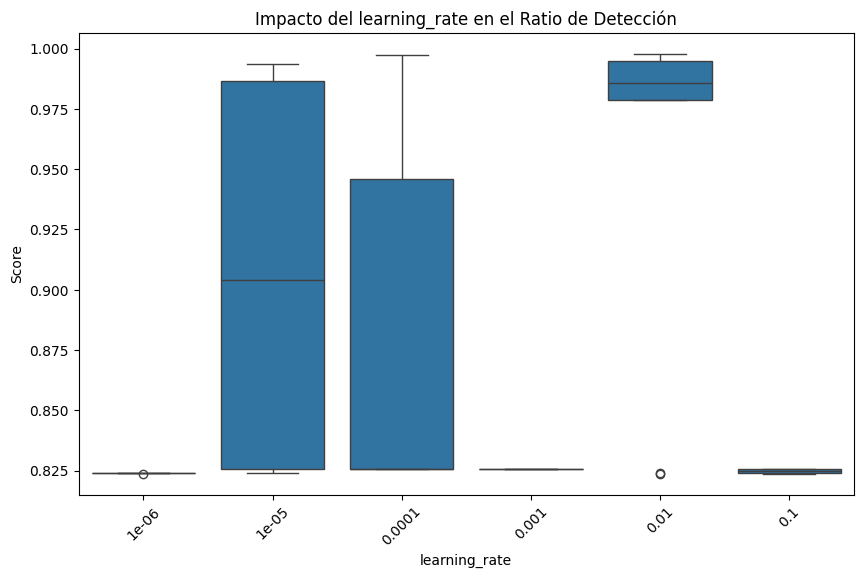

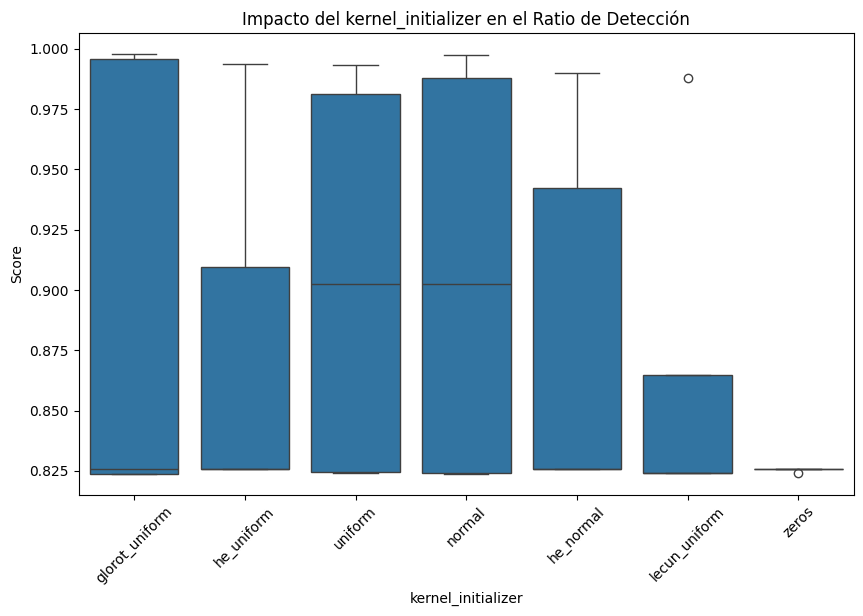

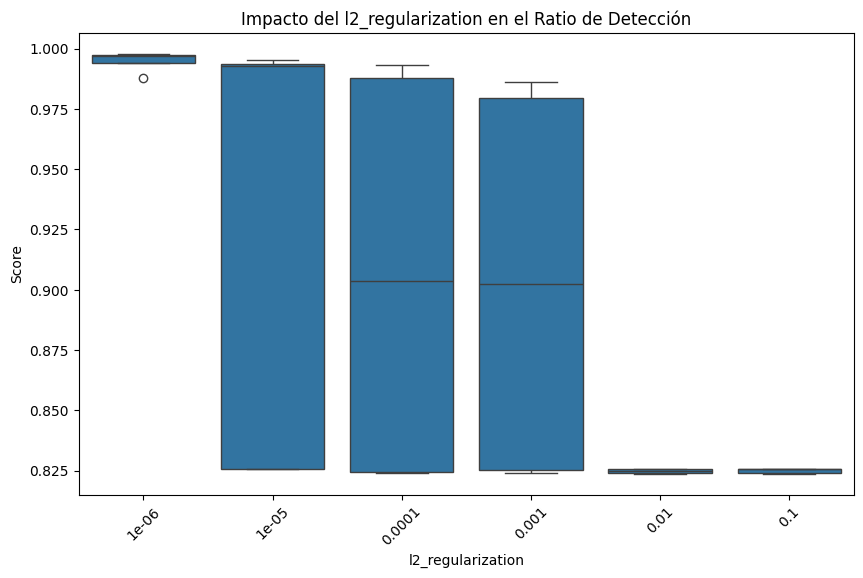

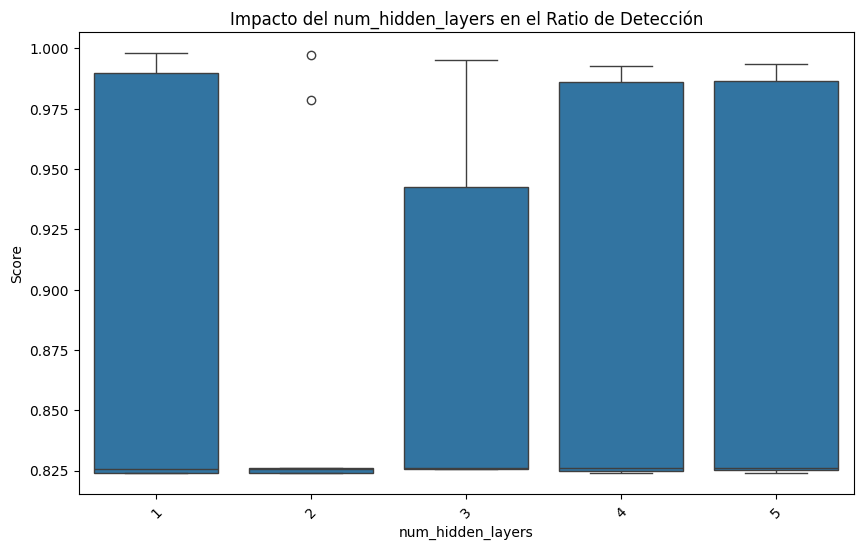

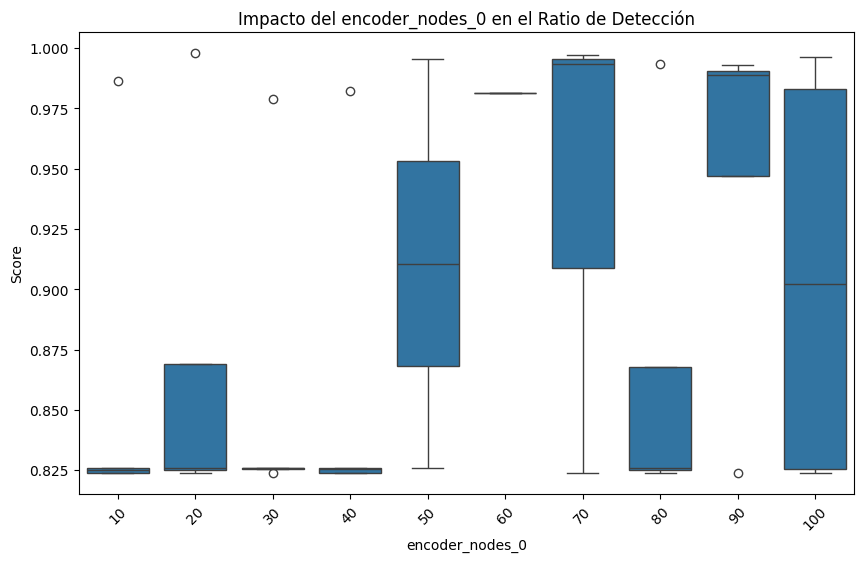

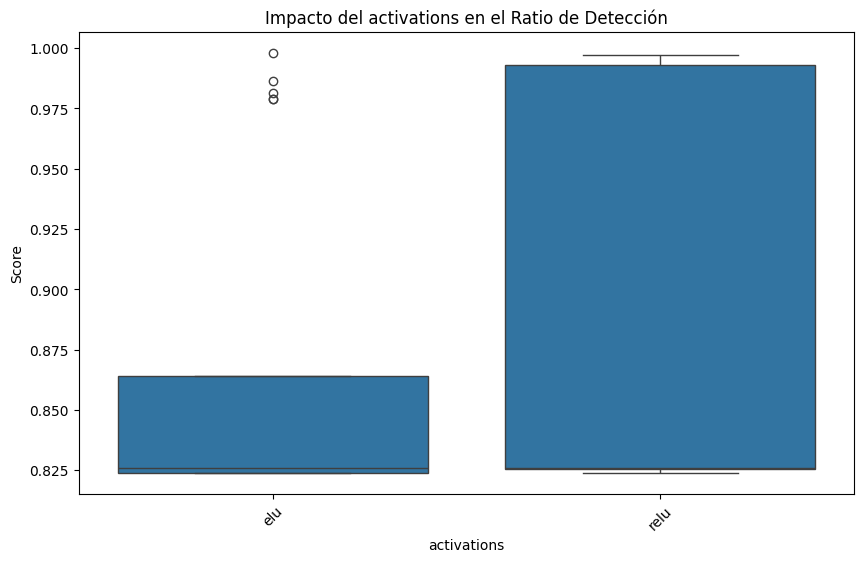

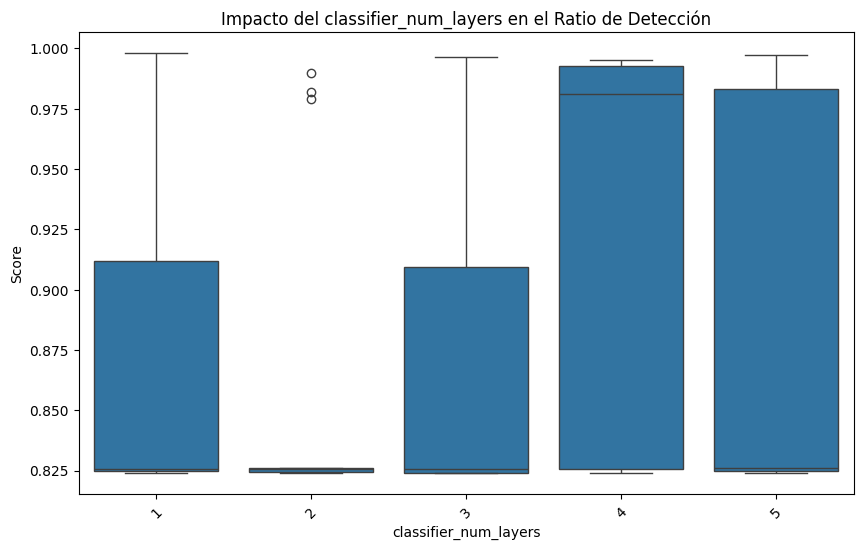

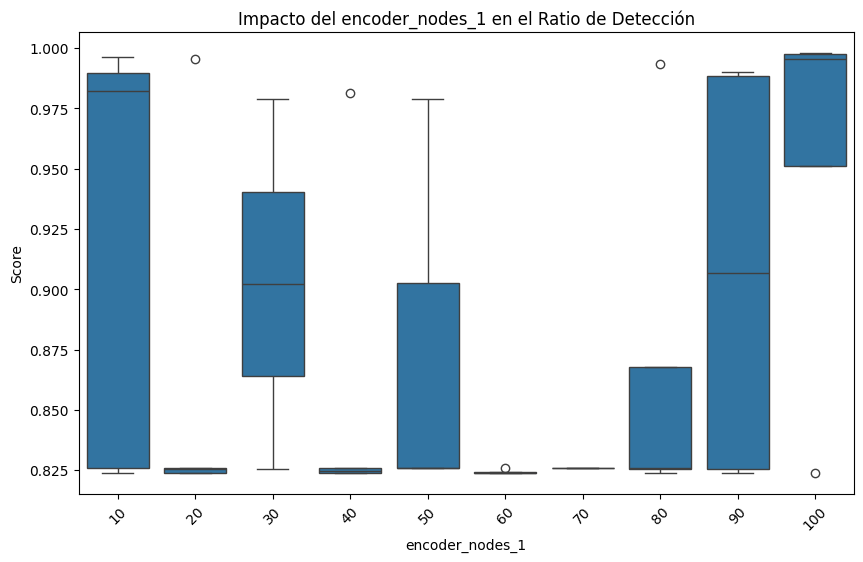

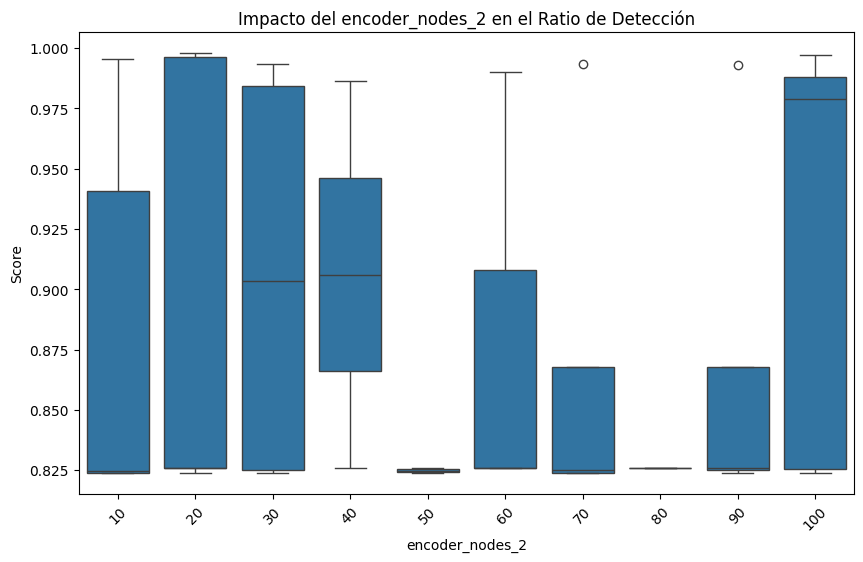

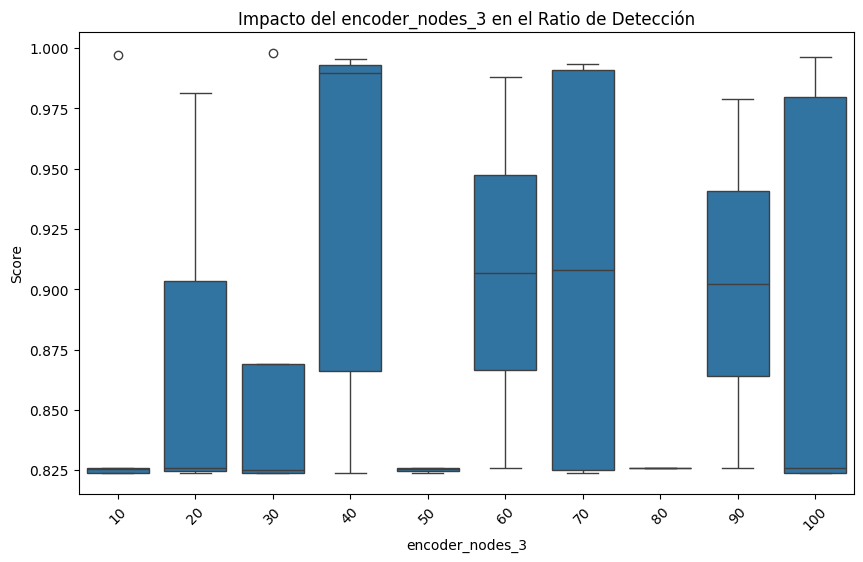

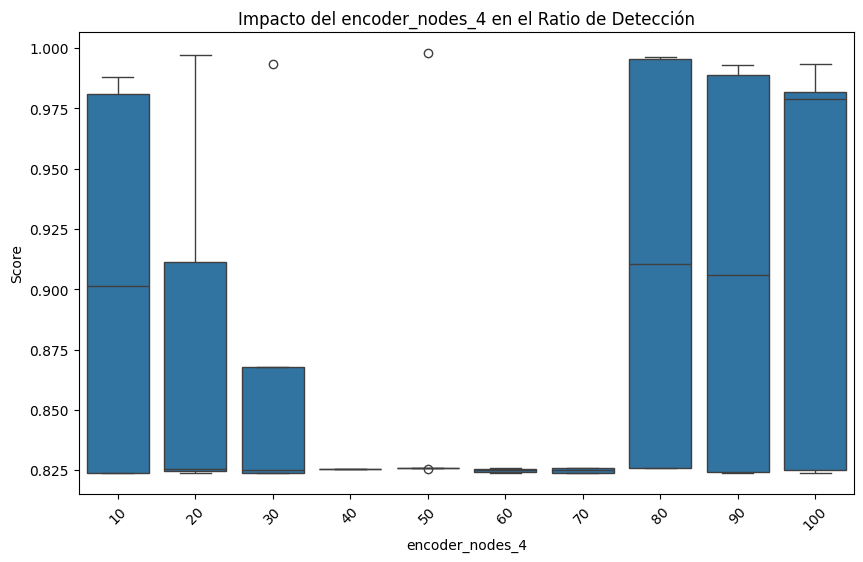

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

hp_list = [ 'learning_rate', 'kernel_initializer',
       'l2_regularization', 'num_hidden_layers', 'activations', 'classifier_num_layers',
       ]

nets_list = ['encoder_nodes_0','encoder_nodes_1',
       'encoder_nodes_2', 'encoder_nodes_3', 'encoder_nodes_4']

# Crear un diagrama de caja para cada hiperparámetro
for col in hp_list:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='score', data=trials_df)
    plt.title(f'Impacto del {col} en el Ratio de Detección')
    plt.ylabel('Score')
    plt.xlabel(col)
    plt.xticks(rotation=45)  # Rota las etiquetas para que pueda ser legible
    plt.show()


<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
<ipython-input-27-1f2c7742883e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)
<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
<ipython-input-27-1f2c7742883e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)
<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xti

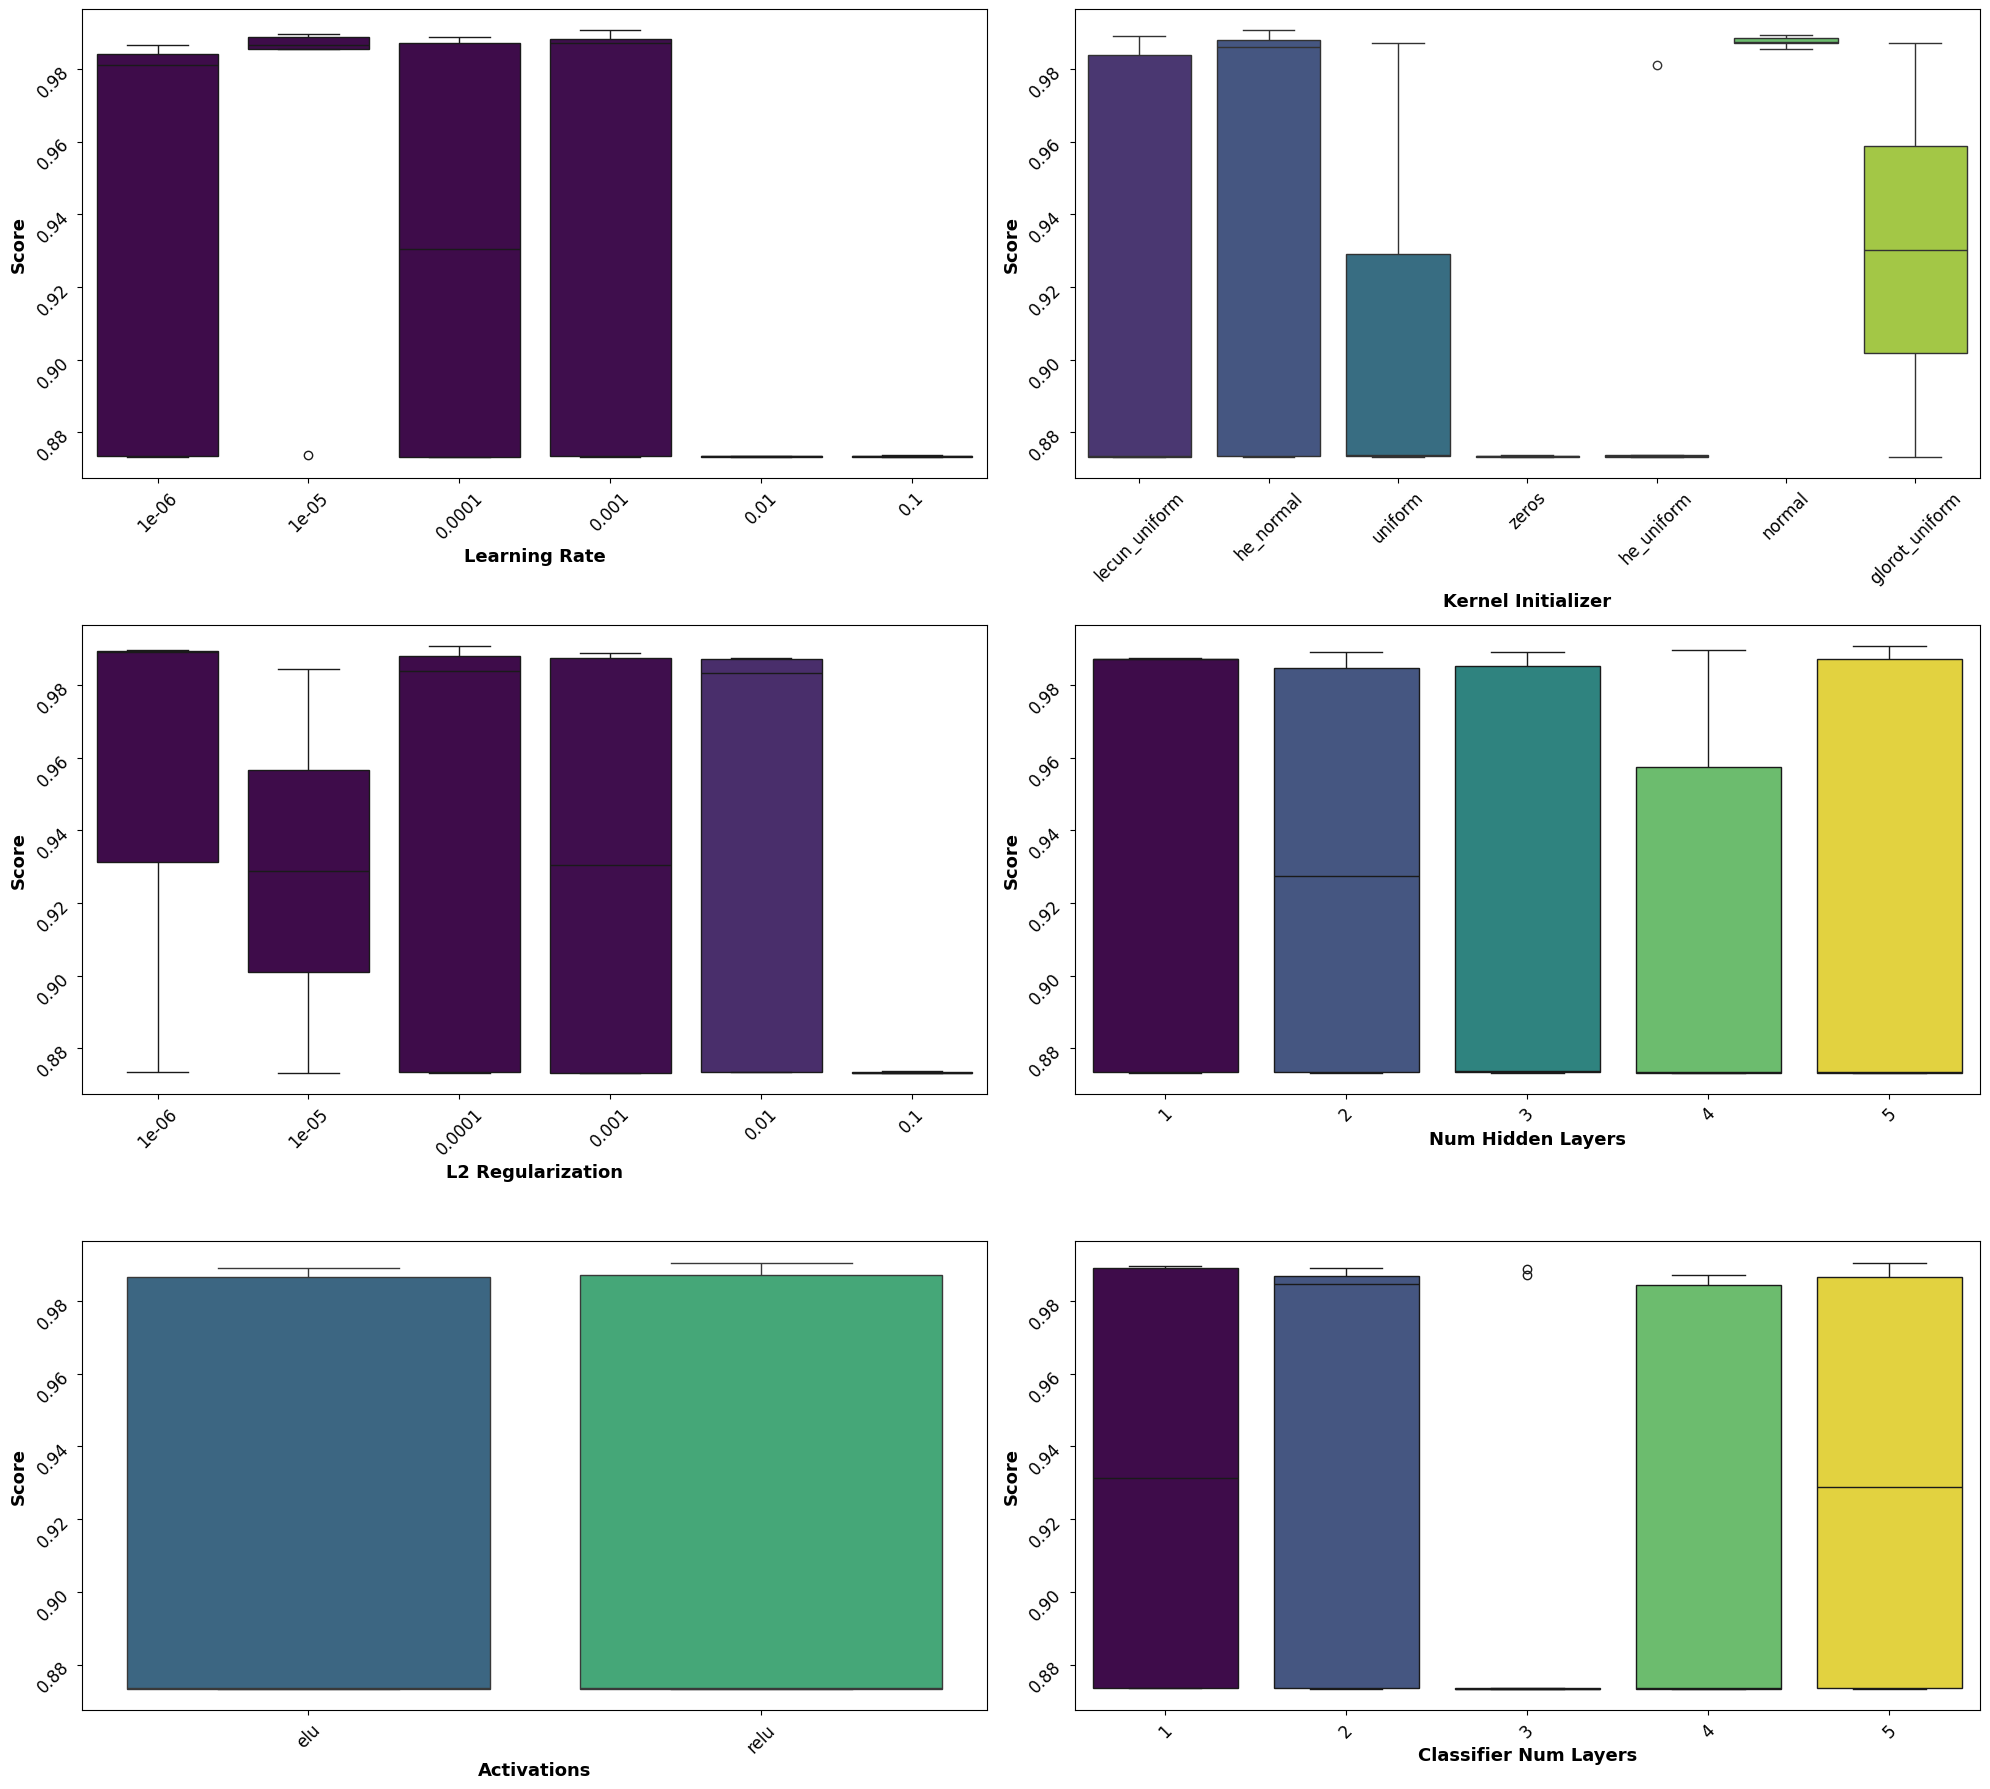

<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
<ipython-input-27-1f2c7742883e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)
<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
<ipython-input-27-1f2c7742883e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)
<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xti

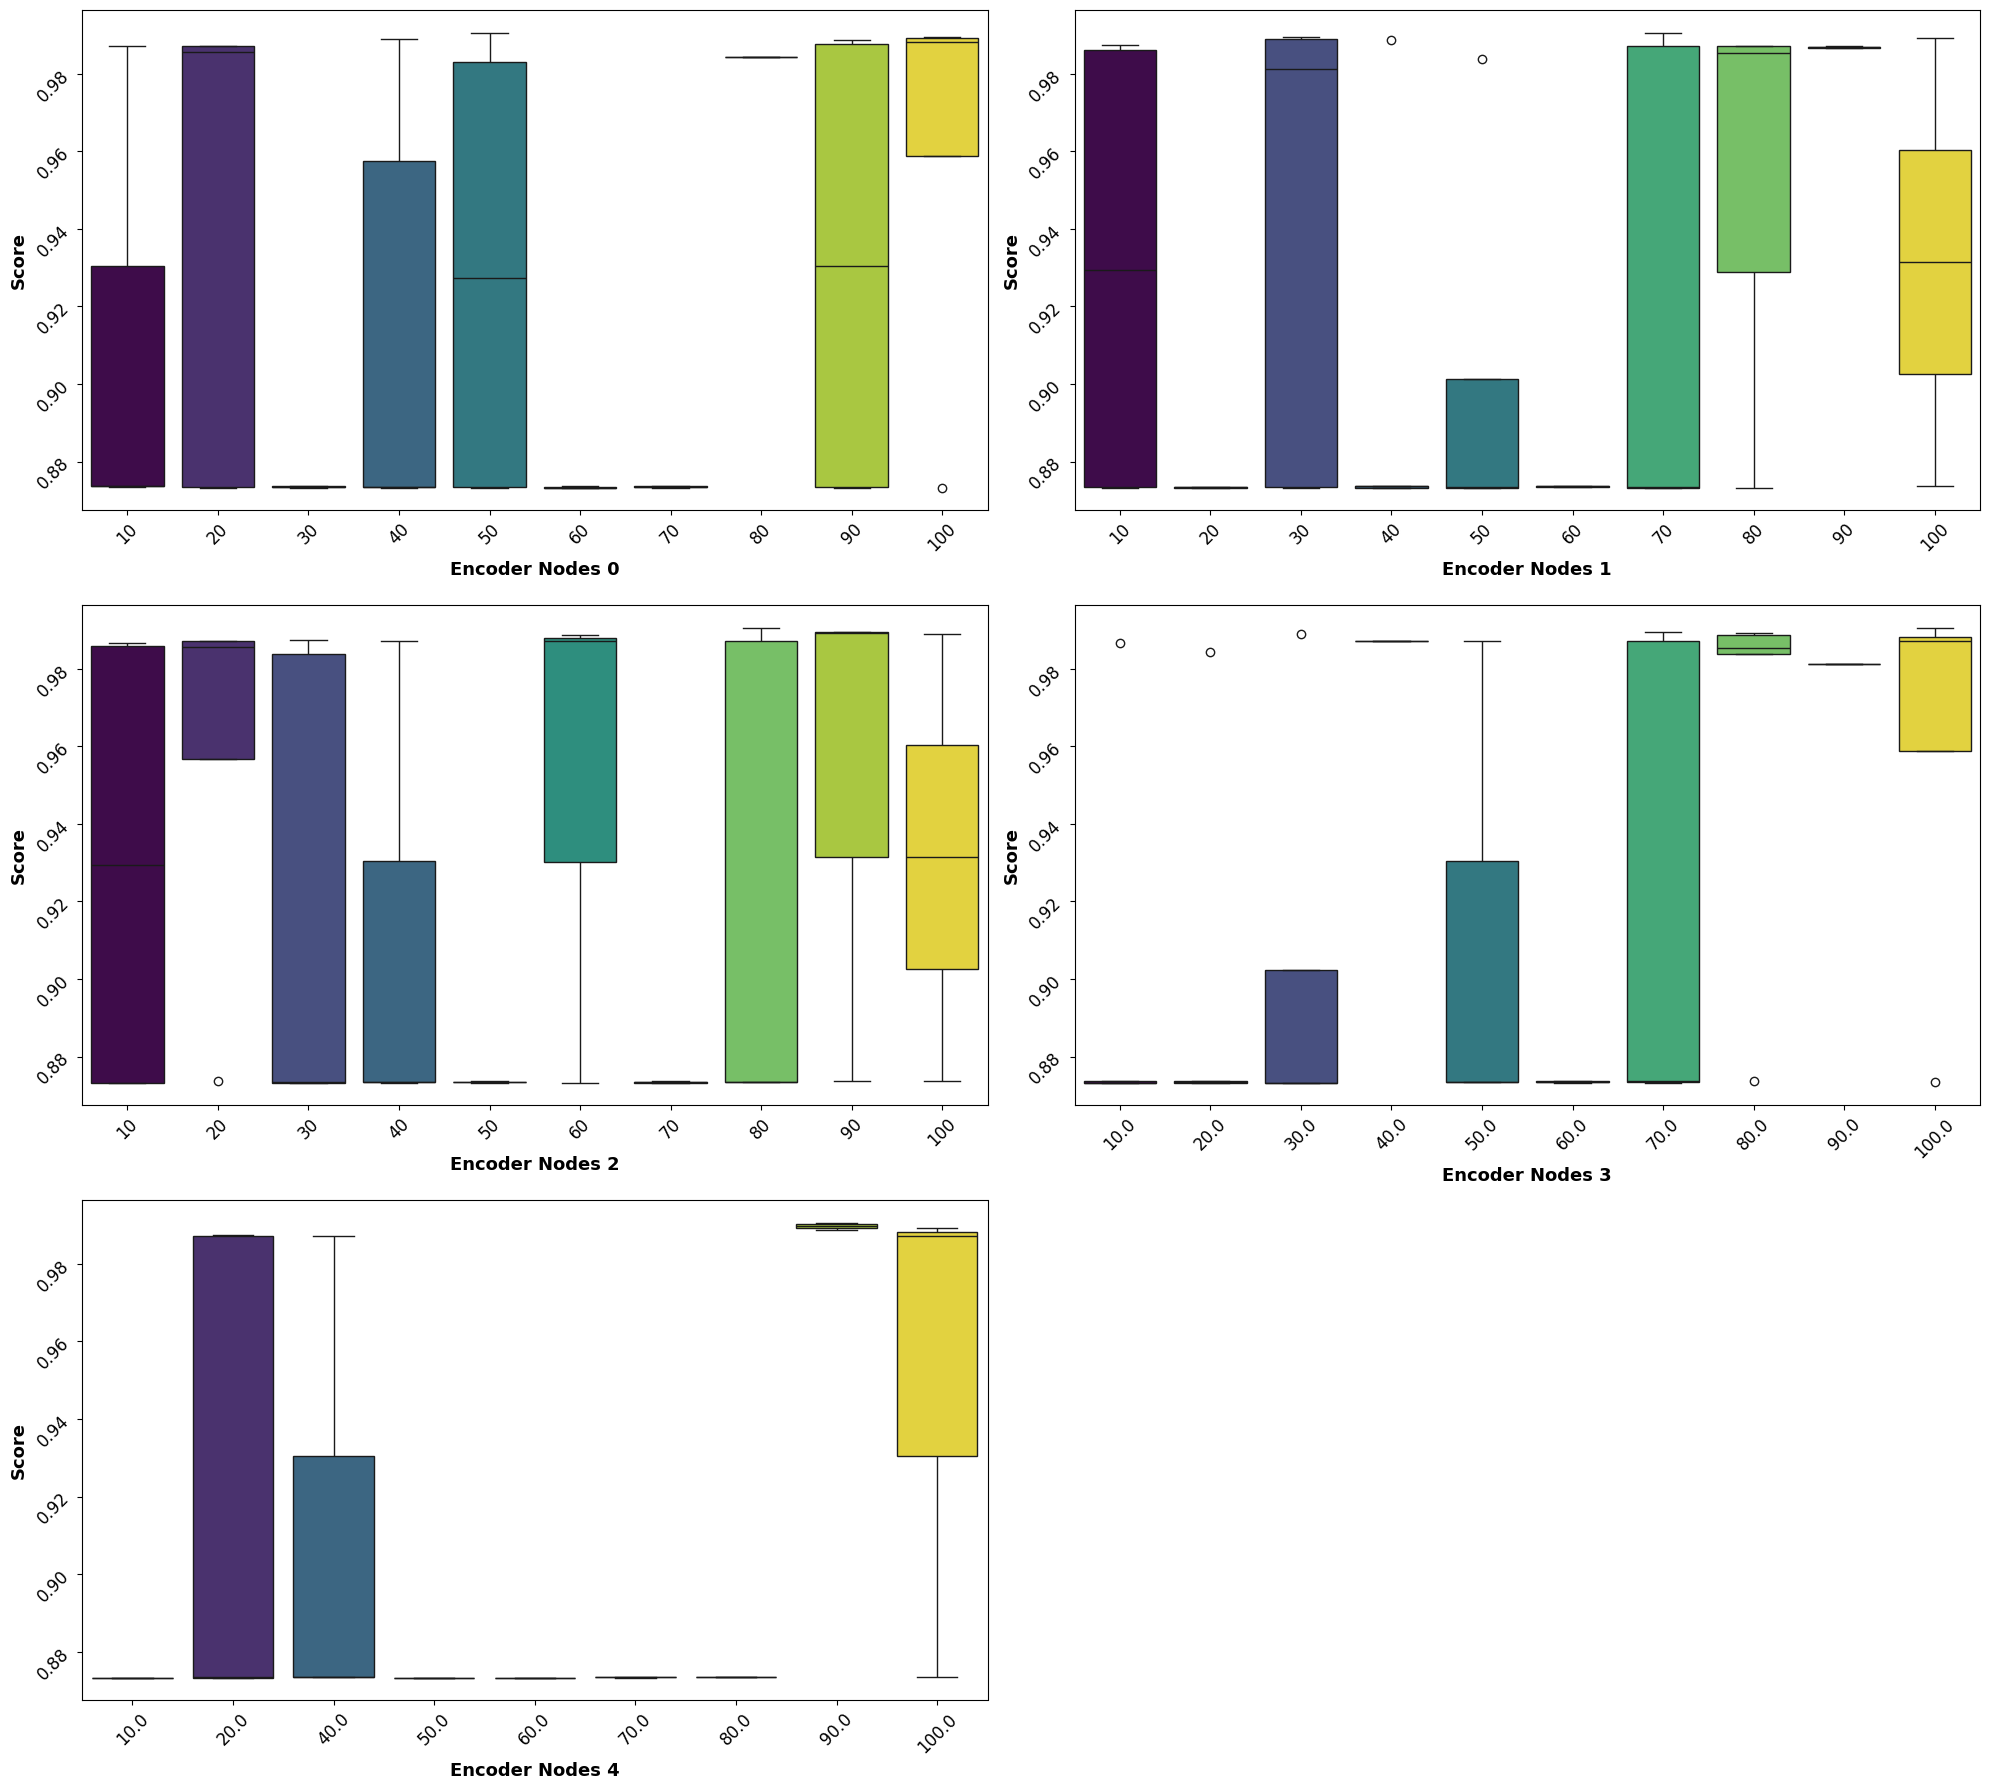

<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
<ipython-input-27-1f2c7742883e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)
<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
<ipython-input-27-1f2c7742883e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)
<ipython-input-27-1f2c7742883e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xti

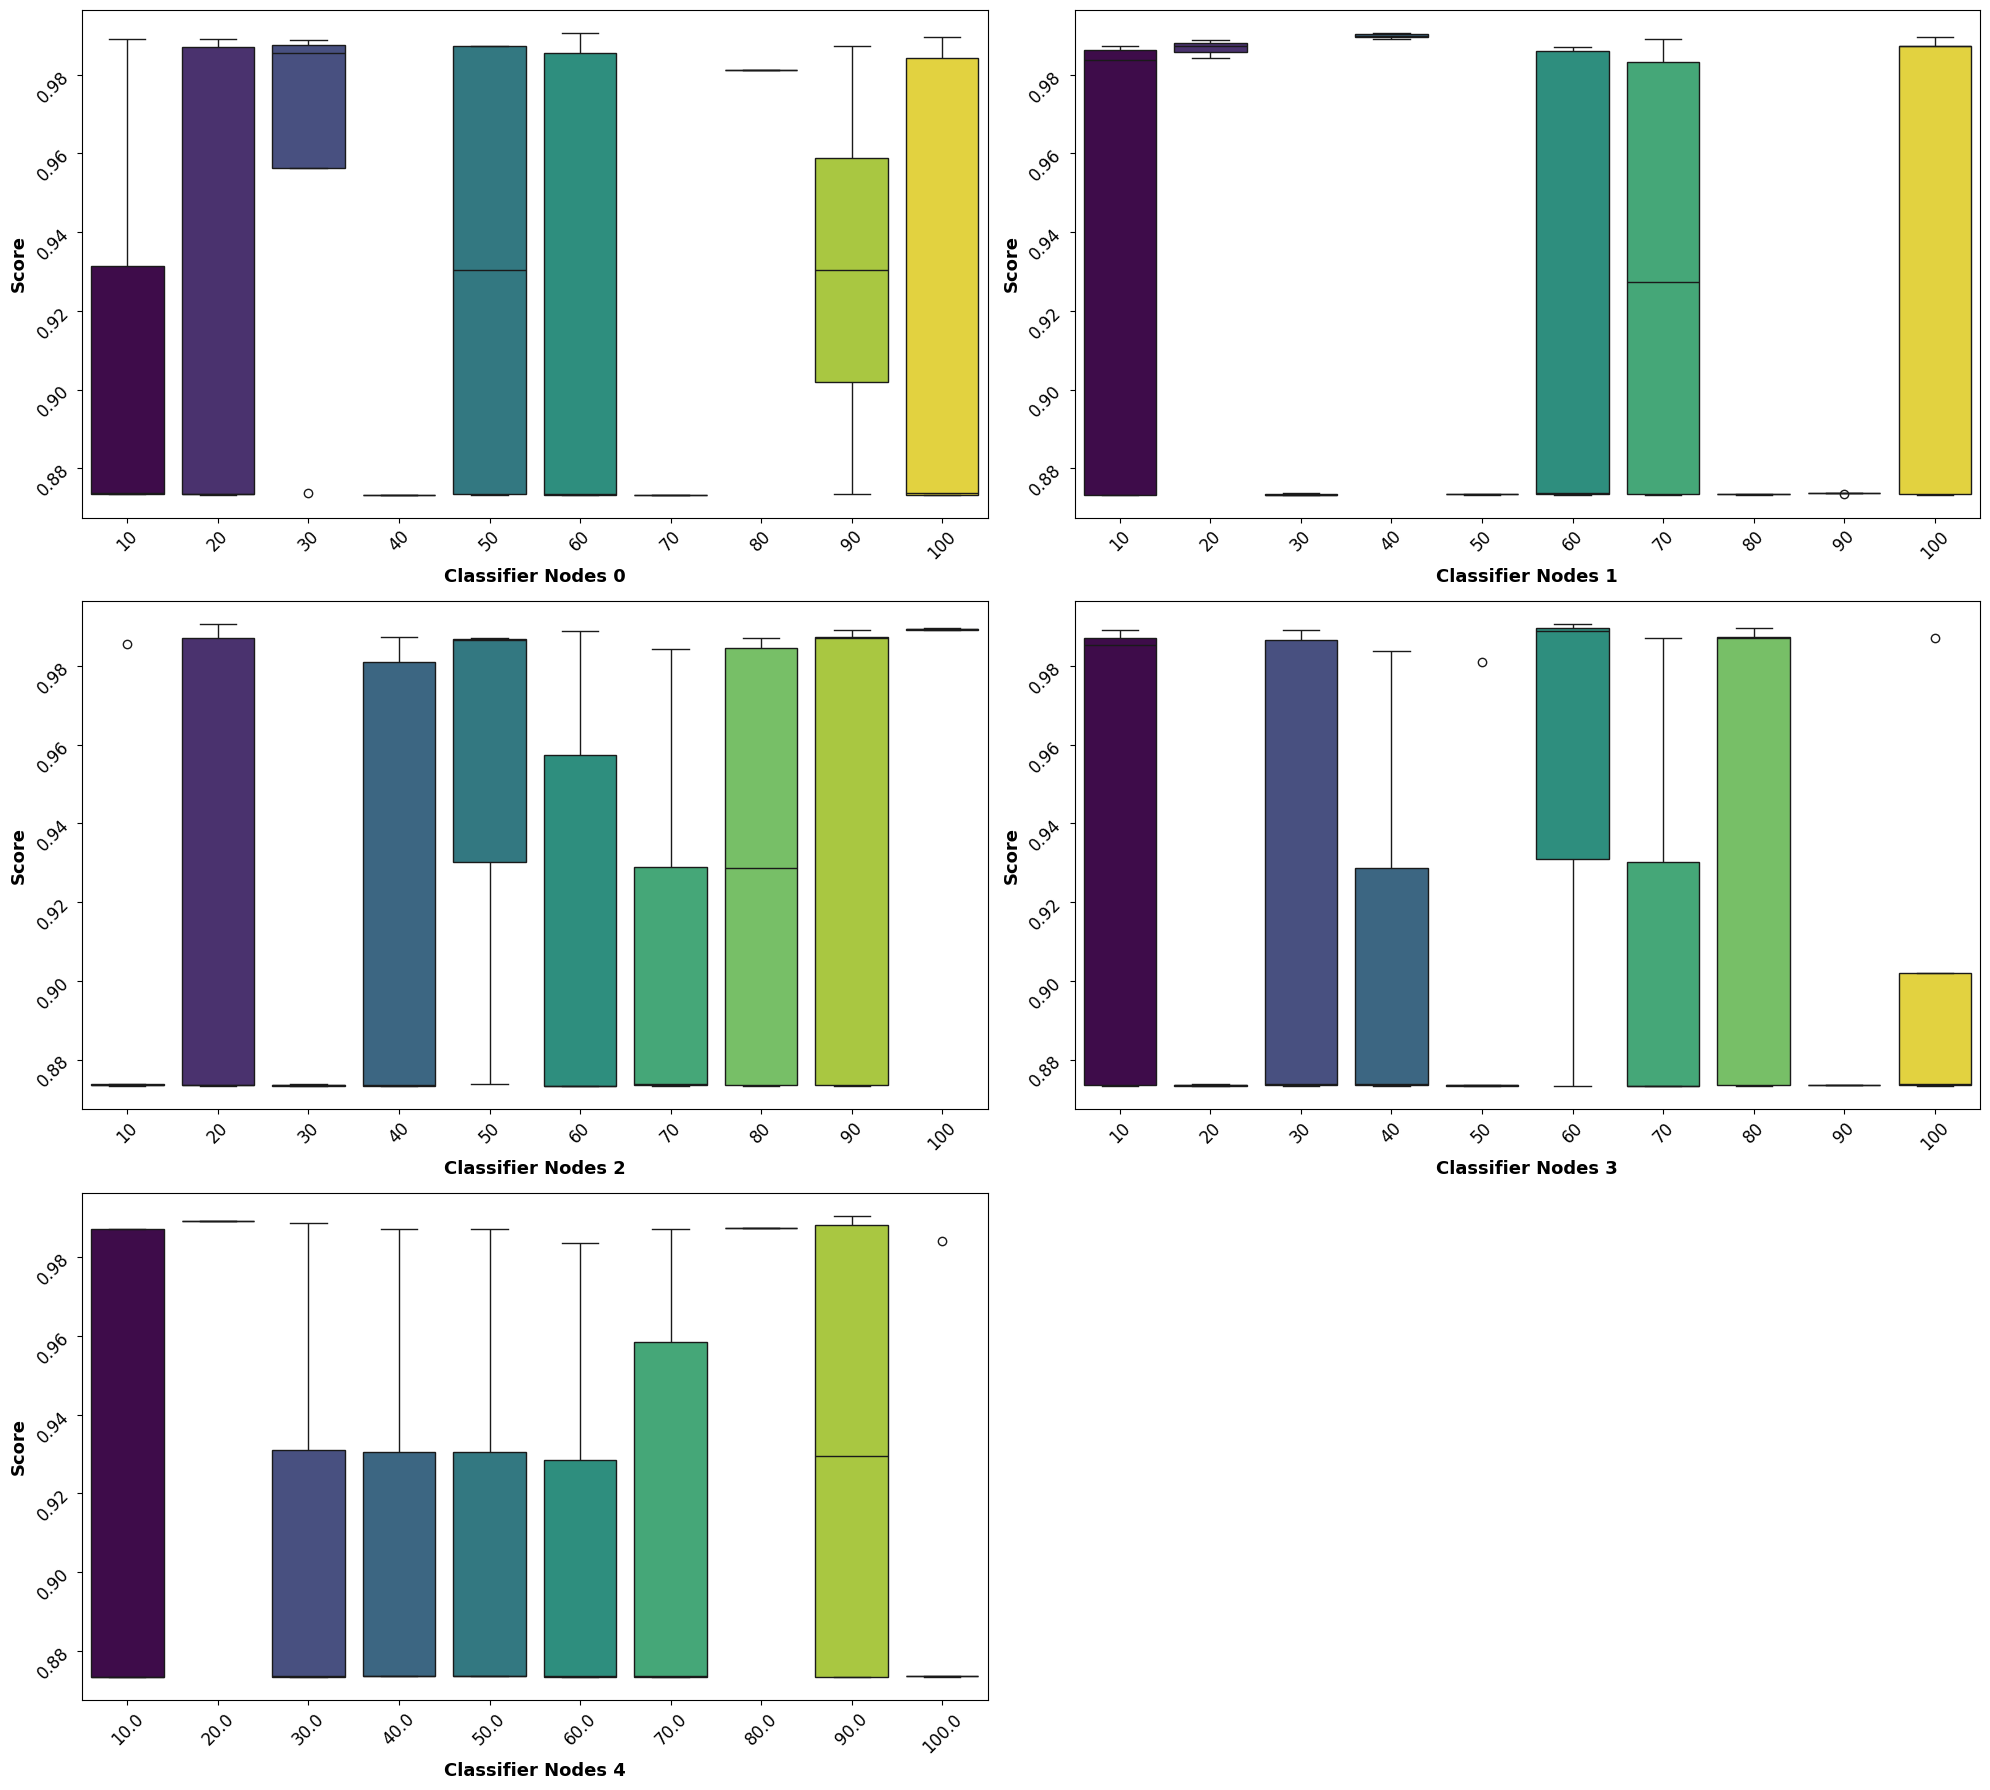

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

hp_list = [ 'learning_rate', 'kernel_initializer',
       'l2_regularization', 'num_hidden_layers', 'activations', 'classifier_num_layers',
       ]

encoder_list = ['encoder_nodes_0','encoder_nodes_1',
       'encoder_nodes_2', 'encoder_nodes_3', 'encoder_nodes_4']

classifier_list = ['classifier_nodes_0', 'classifier_nodes_1', 'classifier_nodes_2', 'classifier_nodes_3', 'classifier_nodes_4']
plots = [hp_list, nets_list, classifier_list]



for hp_list in plots:
  # Crear una figura con subplots
  num_rows = len(hp_list) // 2 if len(hp_list) % 2 == 0 else len(hp_list) // 2 + 1

  # Crear una figura con subplots
  fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6*num_rows))


  axs = axs.flatten()

  for i, col in enumerate(hp_list):
      sns.boxplot(x=col, y='score', hue=col, data=trials_df, ax=axs[i], palette='viridis', legend=False)
      # axs[i].set_title(f'Impacto del {col.replace("_", " ").title()} en el Ratio de Detección')
      axs[i].set_ylabel('Score', fontweight='bold', fontsize=13)
      axs[i].set_xlabel(col.replace("_", " ").title(), fontweight='bold', fontsize=13)
      axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize=12)  # Rota las etiquetas para que pueda ser legible
      axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=45, fontsize=12)

  # Eliminar los subplots vacíos si el número de hiperparámetros es impar
  if len(hp_list) % 2 != 0:
    fig.delaxes(axs[-1])


  plt.tight_layout()
  plt.show()

## Evaluación y Comparación de modelos

In [ ]:
X = df.drop('Label', axis=1)
y = df['Label']

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    stratify=y,
    random_state=42
)
csecic_classes = y[1].size
input_dim = len(X.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# NSL KDD - UNW NB15

X = df.drop('Label', axis=1)
y = df['Label']
if not np.issubdtype(df['Label'].dtype, np.number):
  y = df['Label'].map({'anomaly': 1, 'normal': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    stratify=y,
    random_state=42
)

input_dim = len(X.columns)

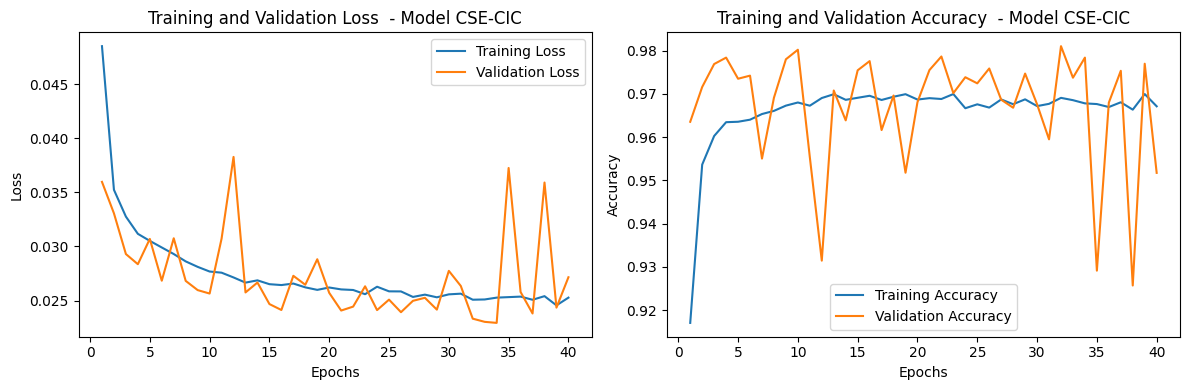

In [ ]:
import matplotlib.pyplot as plt

# Función para graficar las curvas de aprendizaje
def plot_learning_curves(history, title=''):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con el historial de entrenamiento cargado
plot_learning_curves(history, title=f' - Model {dataset_name.upper()}')



**`Loss` (Pérdida)**

La pérdida es una medida de qué tan mal está desempeñándose el modelo en su tarea de predicción. Durante el entrenamiento de un modelo de aprendizaje automático, el objetivo es minimizar la función de pérdida. En una curva de aprendizaje:

- **Entrenamiento:** La curva de pérdida del entrenamiento debería disminuir progresivamente. Una pérdida alta al inicio es esperada, pero debería reducirse a medida que el modelo aprende.
- **Validación:** La curva de pérdida de validación también debería disminuir. Sin embargo, si empieza a aumentar después de un punto, esto puede indicar sobreajuste, es decir, el modelo está memorizando los datos de entrenamiento en lugar de generalizar a datos nuevos.

**`Accuracy` (Precisión)**

La precisión es la proporción de predicciones correctas sobre el total de predicciones realizadas. En una curva de aprendizaje:

- **Entrenamiento:** La curva de precisión del entrenamiento debería aumentar a medida que el modelo mejora. Un incremento constante es señal de que el modelo está aprendiendo correctamente.
- **Validación:** La curva de precisión de validación debería aumentar también. Si la precisión de validación se estabiliza o disminuye mientras que la de entrenamiento sigue aumentando, esto puede ser una señal de sobreajuste.

**Interpretación Combinada**

- *Buen Ajuste:* Si ambas curvas de pérdida (entrenamiento y validación) disminuyen y las curvas de precisión aumentan, el modelo está aprendiendo correctamente y generalizando bien.
- *Sobreajuste:* Si la pérdida de validación aumenta mientras que la de entrenamiento disminuye, y la precisión de validación se estabiliza o disminuye mientras que la de entrenamiento aumenta, el modelo está sobreajustando.
- *Bajo Ajuste:* Si ambas pérdidas permanecen altas y ambas precisiones permanecen bajas, el modelo no está aprendiendo adecuadamente, lo cual podría deberse a que el modelo es demasiado simple o a que los datos no son adecuados.

Entender estas métricas en el contexto de las curvas de aprendizaje te permitirá ajustar mejor tu modelo y mejorar su rendimiento.


In [ ]:
history

{'verbose': 1, 'epochs': 50, 'steps': 851}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def evaluate_metrics(model, X_test, y_test):
    start_time_pred = time.time()
    predictions = model.predict(X_test)
    end_time_pred = time.time()

    #predictions = np.argmax(predictions, axis=1)  # Convierte a etiquetas desde one-hot
    y_true = y_test #np.argmax(y_test, axis=1)  # Convierte verdaderas etiquetas desde one-hot

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted')
    recall = recall_score(y_true, predictions, average='weighted')
    f1 = f1_score(y_true, predictions, average='weighted')
    prediction_time = end_time_pred - start_time_pred
    num_test_obs = X_test.shape[0]

    print(f"Tiempo de entrenamiento: {training_time/num_train_obs}")
    print(f"Tiempo de predicci'on: {prediction_time/num_test_obs}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1, prediction_time


In [ ]:
#evaluate_metrics(model, X_test, y_test)

start_time_pred = time.time()
predictions = model.predict(X_test)
end_time_pred = time.time()

12701/12701 [==============================] - 23s 2ms/step


In [ ]:
y_pred = (predictions > 0.5).astype(int).flatten()

# Calcular métricas de rendimiento
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Número de observaciones
num_train_obs = X_train.shape[0]
num_test_obs = X_test.shape[0]

# Resultados formales
results = (
    f"Tiempo de entrenamiento: {training_time:.4f} segundos\n"
    f"Tiempo de predicción: {prediction_time:.4f} segundos\n"
    f"Número de observaciones de entrenamiento: {num_train_obs}\n"
    f"Número de observaciones de prueba: {num_test_obs}\n"
    f"Exactitud: {accuracy:.4f}\n"
    f"Precisión: {precision:.4f}\n"
    f"Recall: {recall:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
)

print(results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tiempo de entrenamiento: 79.8256 segundos
Tiempo de predicción: 191.2254 segundos
Número de observaciones de entrenamiento: 1219218
Número de observaciones de prueba: 406407
Exactitud: 0.8735
Precisión: 0.0000
Recall: 0.0000
F1 Score: 0.0000



In [ ]:
# CSE CIC
x_test = preLayer(X_test.copy())

evaluate_metrics(model, x_train, y_test)

In [ ]:
# NSL KDD
x_test = preLayer(X_test.copy())

evaluate_metrics(model, x_train, y_test)

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_multiclass_roc_auc(model, X_test, y_test, classes):

    y_score = model.predict(X_test)

    # Configurar la figura para ROC
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

    # Calcular ROC y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, color in zip(range(len(classes)), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of ROC to multi-class')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

Procediendo al one hot encoding
Procediendo a la codificacion por frecuencias
2836/2836 [==============================] - 9s 3ms/step


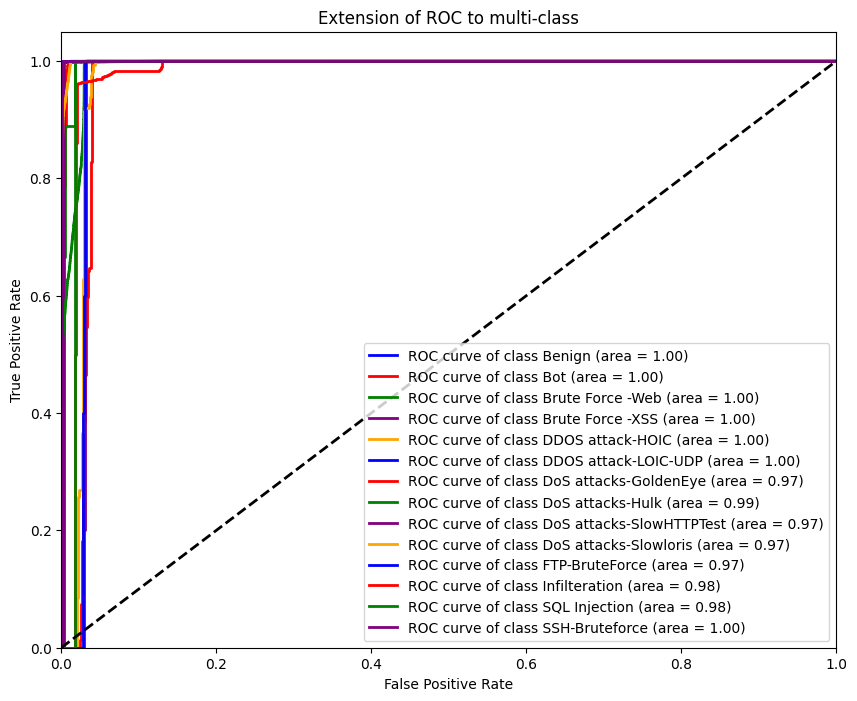

{0: 0.9998335628402794,
 1: 0.9978869653708815,
 2: 0.99579106952389,
 3: 0.9970519517732371,
 4: 0.9990351206986969,
 5: 1.0,
 6: 0.9672259498305619,
 7: 0.99100648761668,
 8: 0.9691812601254175,
 9: 0.9726680790952845,
 10: 0.9708189602918325,
 11: 0.978981433496316,
 12: 0.9825214899713467,
 13: 0.9996812960856507}

In [ ]:
plot_multiclass_roc_auc(model, preLayer(X_test.copy()), y_test, df['Label'].unique())

In [ ]:
import numpy as np
import pandas as pd

class DataPartitioner:
    def __init__(self, df: pd.DataFrame, seed: int = 42):
        self.df = df
        self.seed = seed
        np.random.seed(self.seed)

    @staticmethod
    def split_dataset(data, n_splits, seed=None):
        """
        Split a DataFrame into n approximately equal parts, storing them in a dictionary.

        Parameters:
        - data (pd.DataFrame): The dataset to be split.
        - n_splits (int): The number of parts to divide the dataset into.
        - seed (int, optional): A seed for random number generation to ensure replicability.

        Returns:
        - dict: A dictionary with numerical keys (0 to n_splits-1) and DataFrame parts as values.
        """
        if seed is not None:
            np.random.seed(seed)

        # Shuffle the indices of the dataframe
        shuffled_indices = np.random.permutation(len(data))

        # Split indices into n parts
        split_indices = np.array_split(shuffled_indices, n_splits)

        # Create a dictionary to hold the dataframe splits
        splits = {i: data.iloc[indices] for i, indices in enumerate(split_indices)}

        return splits

    @staticmethod
    def split_dataset_by_percentage(data, percentage, seed=None):
        """
        Split a DataFrame into two parts based on a percentage.

        Parameters:
        - data (pd.DataFrame): The dataset to be split.
        - percentage (float): The percentage of the dataset to include in the first split (0-100).
        - seed (int, optional): A seed for random number generation to ensure replicability.

        Returns:
        - tuple: A tuple containing two DataFrames, the first with 'percentage' of the data,
                and the second with the remaining (100-percentage)% of the data.
        """
        if seed is not None:
            np.random.seed(seed)


        split_index = int(len(data) * (percentage / 100))


        shuffled_indices = np.random.permutation(len(data))


        first_split_indices = shuffled_indices[:split_index]
        second_split_indices = shuffled_indices[split_index:]


        first_split = data.iloc[first_split_indices]
        second_split = data.iloc[second_split_indices]

        return {'p_data':first_split, 'remainning_data':second_split}

In [ ]:
DataPartitioner.split_dataset_by_percentage(df, 10)

{'p_data':          index  Flow Pkts/s  Fwd Pkt Len Mean  Tot Fwd Pkts  \
 412794  412930     5.762354        102.214286            14   
 860098  860280    44.579173          0.000000             3   
 861477  861659   178.062678          0.000000             2   
 12755    12768     5.151668        127.555556             9   
 691739  691916     0.026635          0.000000             3   
 ...        ...          ...               ...           ...   
 561616  561779  2528.445006         36.000000             1   
 565377  565541     5.642805        104.285714            14   
 889261  889465     0.236272          0.000000             1   
 107220  107274    46.426333         40.000000             2   
 760430  760612   655.124006        108.666667             3   
 
         Init Fwd Win Byts  Fwd Seg Size Avg  Subflow Fwd Pkts  ACK Flag Cnt  \
 412794               8192        102.214286                14             0   
 860098                225          0.000000                